<a href="https://colab.research.google.com/github/YANG-SOBER/Deep-Learning-for-Computer-Vision/blob/main/Asgn-3/convolutional_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EECS 498-007/598-005 Assignment 3-2: Convolutional Neural Networks and Batch Normalization

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Your NAME, #XXXXXXXX

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as Assignment 1. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['convolutional_networks.ipynb', 'fully_connected_networks.ipynb', 'eecs598', 'convolutional_networks.py', 'fully_connected_networks.py', 'a3_helper.py']
```

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A3 folder, then '2020FA/A3'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'A3'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['convolutional_networks.ipynb', 'fully_connected_networks.ipynb', 'eecs598', '__pycache__', 'best_two_layer_net.pth', 'best_overfit_five_layer_net.pth', 'fully_connected_networks.py', 'a3_helper.py', 'one_minute_deepconvnet.pth', 'convolutional_networks.py', 'overfit_deepconvnet.pth']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from convolutional_networks.py!
Hello from a3_helper.py!
```

as well as the last edit time for the file `convolutional_networks.py`.

In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from convolutional_networks import hello_convolutional_networks
hello_convolutional_networks()

from a3_helper import hello_helper
hello_helper()

convolutional_networks_path = os.path.join(GOOGLE_DRIVE_PATH, 'convolutional_networks.py')
convolutional_networks_edit_time = time.ctime(os.path.getmtime(convolutional_networks_path))
print('convolutional_networks.py last edited on %s' % convolutional_networks_edit_time)

Hello from convolutional_networks.py!
Hello from a3_helper.py!
convolutional_networks.py last edited on Tue May 24 03:54:11 2022


# Data preprocessing

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [ ]:
import torch
torch.cuda.is_available()

True

## Load the CIFAR-10 dataset
Then, we will first load the CIFAR-10 dataset, same as knn. The utility function `get_CIFAR10_data()` in `helper_functions` returns the entire CIFAR-10 dataset as a set of six **Torch tensors** while also preprocessing the RGB images:

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

In [ ]:
import torch
import torchvision
import os
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [ ]:
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['font.size'] = 16.0

In [ ]:
def get_tensors(dset, num=None, dtype=torch.float32):

  # from np.ndarray uint8 [0, 255] (N, H, W, C) to torch.Tensor float32 [0.0, 1.0] (N, C, H, W) 
  X = torch.tensor(dset.data, dtype=dtype).permute(0, 3, 1, 2).div_(255)
  y = torch.tensor(dset.targets, dtype=torch.int64)
  if num is not None:
    if num <= 0 and num > X.shape[0]:
      raise ValueError("Invalid Error!!! num should be in the range [0, {}]".format(X.shape[0]))
    else:
      X = X[:num].clone()
      y = y[:num].clone()

  return X, y

In [ ]:
def cifar10(num_train=None, num_test=None, dtype=torch.float32):

  download = not os.path.isdir('cifar-10-batches-py')

  training_set = torchvision.datasets.CIFAR10(root='.', train=True, download=download)
  test_set = torchvision.datasets.CIFAR10(root='.', train=False, download=download)
  X_train, y_train = get_tensors(dset=training_set, num=num_train, dtype=dtype)
  X_test, y_test = get_tensors(dset=test_set, num=num_test, dtype=dtype)

  return training_set, X_train, y_train, X_test, y_test

In [ ]:
def preprocess_cifar10(cuda=True, show_examples=True, bias_trick=True, flatten=True, validation_ratio=0.2, dtype=torch.float32):
  
  training_set, X_train, y_train, X_test, y_test = cifar10(dtype=dtype)

  if cuda:
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()
  
  if show_examples:
    imgs_list = []
    imgs_per_class = 12
    class_names = training_set.classes # a list storing class names
    for yi, cls in enumerate(class_names): # yi is the label for correct class
      plt.text(-4, 34*yi+18, cls, ha='right')
      idxs, = (yi == y_train).nonzero(as_tuple=True) # pick the img indexs corresponding to label yi
      for i in range(imgs_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item()
        img = X_train[idx]
        imgs_list.append(img)
    img_grid = torchvision.utils.make_grid(imgs_list, nrow=imgs_per_class, pad_value=1)
    img_grid = img_grid.mul_(255).add_(0.5).clamp(0, 255).permute(1, 2, 0).to(dtype=torch.uint8, device='cpu')
    plt.imshow(img_grid.numpy())
    plt.axis('off')
  
  train_mean = X_train.mean(dim=(0, 2, 3), keepdim=True, dtype=X_train.dtype)
  X_train = X_train - train_mean
  X_test = X_test - train_mean

  if flatten:
    X_train = X_train.view((X_train.shape[0], -1))
    X_test = X_test.view((X_test.shape[0], -1))

  if flatten and bias_trick:
    train_ones = X_train.new_ones((X_train.shape[0], 1))
    test_ones = X_test.new_ones((X_test.shape[0], 1))
    X_train = torch.cat((X_train, train_ones), dim=1)
    X_test = torch.cat((X_test, test_ones), dim=1)
  
  data_dict = {}
  num_train = int(X_train.shape[0] * (1.0 - validation_ratio))
  num_val = X_train.shape[0] - num_train
  data_dict['X_train'] = X_train[:num_train]
  data_dict['X_val'] = X_train[num_train: num_train+num_val]
  data_dict['X_test'] = X_test
  data_dict['y_train'] = y_train[:num_train]
  data_dict['y_val'] = y_train[num_train: num_train+num_val]
  data_dict['y_test'] = y_test

  return data_dict

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
Train data shape:  torch.Size([40000, 3, 32, 32])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3, 32, 32])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3, 32, 32])
Test labels shape:  torch.Size([10000])


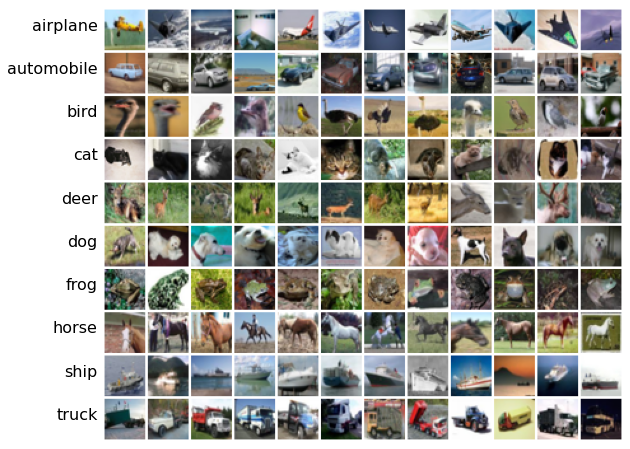

In [ ]:
# Invoke the above function to get our data. 
#import eecs598

random.seed(0)
data_dict = preprocess_cifar10(cuda=True, dtype=torch.float64, flatten=False)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

# Convolutional networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

# Convolutional layer
As in the previous notebook, we will package each new neural network operator in a class that defines a `forward` and `backward` function.

## Convolutional layer: forward
The core of a convolutional network is the convolution operation. Implement the forward pass for the convolution layer in the function `Conv.forward`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

After implementing the forward pass of the convolution operation, run the following to check your implementation. You should get a relative error less than `1e-7`.

In [ ]:
import eecs598

In [ ]:
class Conv(object):

  @staticmethod
  def forward(x, w, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.
    The input: (N, C, H, W)
    We convolve each input with F different filters, where each filter spans all
    C channels and has height HH and width WW.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param:
     - 'stride': the number of pixels between adjacent receptive fields
      in the horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input

    During padding, 'pad' zeros should be placed systematically (i.e. equally on both
    sides) along the height and width axes of the input. Be cafeful not to modify
    the original input x directly.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2*pad - HH) / stride
      W' = 1 + (W + 2*pad - WW) / stride
    - cache: (x, w, b, conv_param)
    """

    N, C, H, W = x.shape
    F, C, HH, WW = w.shape
    stride = conv_param['stride']
    pad = conv_param['pad']

    H_out = int(1 + (H + 2*pad - HH) / stride)
    W_out = int(1 + (W + 2*pad - WW) / stride)

    out = torch.zeros((N, F, H_out, W_out), dtype=x.dtype, device=x.device)
    ################################## Forward Pass #########################################

    # x_pad: (N, C, H+2*pad, W+2*pad)
    p2d = (pad,)*4
    x_pad = torch.nn.functional.pad(x, p2d, 'constant', 0)
    
    H_index_max = 1 + (x_pad.shape[2] - HH)
    W_index_max = 1 + (x_pad.shape[3] - WW)


    # Iterate over the data samples
    for n, x_data in enumerate(x_pad):
      # Iterate over the filters
      for f, filter in enumerate(w):
        ############################# Implementation I ################################
        """
        # Iterate over the column dimension:
        for out_j, j in enumerate(range(0, x_pad.shape[2], stride)):
          # Iterate over the width dimension
          if j + HH > x_pad.shape[2]:
            break
          for out_i, i in enumerate(range(0, x_pad.shape[3], stride)):
            if i + WW > x_pad.shape[3]:
              break
            out[n, f, out_j, out_i] = (x_data[:, j:j+HH, i:i+WW] * filter).sum() + b[f]
        """
        #################################################################################

        ############################ Implementation II ###############################
        # Iterate over the column dimension
        for out_j, j in enumerate(range(0, H_index_max, stride)):
          for out_i, i in enumerate(range(0, W_index_max, stride)):
            out[n, f, out_j, out_i] = (x_data[:, j:j+HH, i:i+WW] * filter).sum() + b[f]

    cache = x, w, b, conv_param

    return out, cache

In [ ]:
#from convolutional_networks import Conv

x_shape = torch.tensor((2, 3, 4, 4))
w_shape = torch.tensor((3, 3, 4, 4))
x = torch.linspace(-0.1, 0.5, steps=torch.prod(x_shape), dtype=torch.float64, device='cuda').reshape(*x_shape)
w = torch.linspace(-0.2, 0.3, steps=torch.prod(w_shape), dtype=torch.float64, device='cuda').reshape(*w_shape)
b = torch.linspace(-0.1, 0.2, steps=3, dtype=torch.float64, device='cuda')

conv_param = {'stride': 2, 'pad': 1}
out, _ = Conv.forward(x, w, b, conv_param)
correct_out = torch.tensor([[[[-0.08759809, -0.10987781],
                              [-0.18387192, -0.2109216 ]],
                             [[ 0.21027089,  0.21661097],
                              [ 0.22847626,  0.23004637]],
                             [[ 0.50813986,  0.54309974],
                              [ 0.64082444,  0.67101435]]],
                            [[[-0.98053589, -1.03143541],
                              [-1.19128892, -1.24695841]],
                             [[ 0.69108355,  0.66880383],
                              [ 0.59480972,  0.56776003]],
                             [[ 2.36270298,  2.36904306],
                              [ 2.38090835,  2.38247847]]]], 
                          dtype=torch.float64, device='cuda',
            )

# Compare your output to ours; difference should be around e-8
print('Testing Conv.forward')
print('difference: ', eecs598.grad.rel_error(out, correct_out))

Testing Conv.forward
difference:  1.0141824738238694e-09


## Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

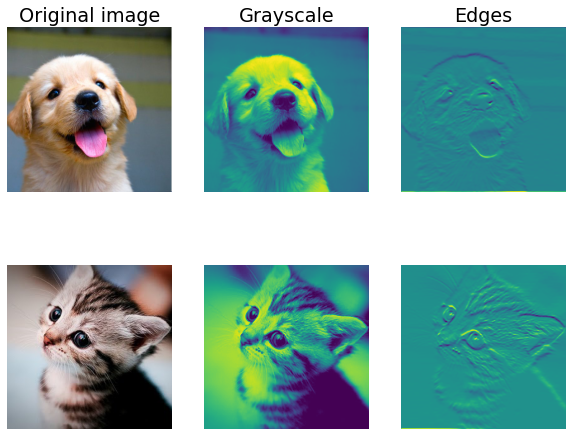

In [ ]:
from imageio import imread
from PIL import Image
from torchvision.transforms import ToTensor

kitten_url = 'https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a3/kitten.jpg'
puppy_url = 'https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a3/puppy.jpg'

kitten = imread(kitten_url)
puppy = imread(puppy_url)
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = ToTensor()(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = ToTensor()(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = torch.stack([resized_puppy, resized_kitten])

# Set up a convolutional weights holding 2 filters, each 3x3
w = torch.zeros(2, 3, 3, 3, dtype=x.dtype)

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = torch.tensor([[0, 0, 0], [0, 0.3, 0], [0, 0, 0]])
w[0, 1, :, :] = torch.tensor([[0, 0, 0], [0, 0.6, 0], [0, 0, 0]])
w[0, 2, :, :] = torch.tensor([[0, 0, 0], [0, 0.1, 0], [0, 0, 0]])

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = torch.tensor([0, 128], dtype=x.dtype)

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = Conv.forward(x, w, b, {'stride': 1, 'pad': 1})

def imshow_no_ax(img, normalize=True):
  """ Tiny helper to show images as uint8 and remove axis labels """
  if normalize:
    img_max, img_min = img.max(), img.min()
    img = 255.0 * (img - img_min) / (img_max - img_min)
  plt.imshow(img)
  plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

## Convolutional layer: backward
Implement the backward pass for the convolution operation in the function `Conv.backward`. Again, you don't need to worry too much about computational efficiency.

After implementing the convolution backward pass, run the following to test your implementation. You should get errors less than `1e-8`.

In [ ]:
class Conv(object):

  @staticmethod
  def forward(x, w, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.
    The input: (N, C, H, W)
    We convolve each input with F different filters, where each filter spans all
    C channels and has height HH and width WW.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param:
     - 'stride': the number of pixels between adjacent receptive fields
      in the horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input

    During padding, 'pad' zeros should be placed systematically (i.e. equally on both
    sides) along the height and width axes of the input. Be cafeful not to modify
    the original input x directly.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2*pad - HH) / stride
      W' = 1 + (W + 2*pad - WW) / stride
    - cache: (x, w, b, conv_param)
    """

    N, C, H, W = x.shape
    F, C, HH, WW = w.shape
    stride = conv_param['stride']
    pad = conv_param['pad']

    H_out = int(1 + (H + 2*pad - HH) / stride)
    W_out = int(1 + (W + 2*pad - WW) / stride)

    out = torch.zeros((N, F, H_out, W_out), dtype=x.dtype, device=x.device)
    ################################## Forward Pass #########################################

    # x_pad: (N, C, H+2*pad, W+2*pad)
    p2d = (pad,)*4
    x_pad = torch.nn.functional.pad(x, p2d, 'constant', 0)
    
    H_index_max = 1 + (x_pad.shape[2] - HH)
    W_index_max = 1 + (x_pad.shape[3] - WW)


    # Iterate over the data samples
    for n, x_data in enumerate(x_pad):
      # Iterate over the filters
      for f, filter in enumerate(w):
        ############################# Implementation I ################################
        """
        # Iterate over the column dimension:
        for out_j, j in enumerate(range(0, x_pad.shape[2], stride)):
          # Iterate over the width dimension
          if j + HH > x_pad.shape[2]:
            break
          for out_i, i in enumerate(range(0, x_pad.shape[3], stride)):
            if i + WW > x_pad.shape[3]:
              break
            out[n, f, out_j, out_i] = (x_data[:, j:j+HH, i:i+WW] * filter).sum() + b[f]
        """
        #################################################################################

        ############################ Implementation II ###############################
        # Iterate over the column dimension
        for out_j, j in enumerate(range(0, H_index_max, stride)):
          for out_i, i in enumerate(range(0, W_index_max, stride)):
            out[n, f, out_j, out_i] = (x_data[:, j:j+HH, i:i+WW] * filter).sum() + b[f]

    cache = x, w, b, conv_param

    return out, cache


  @staticmethod
  def backward(dout, cache):
    """
    A naive implementation of the backward pass for a convolutional layer.

    Inputs:
    - dout: Upstream derivatives.
    - cache: A tuple of (x, w, b, conv_param)

    Returns a tuple of:
    - dx: Gradient (of loss) with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    x, w, b, conv_param = cache
    N, C, H, W = x.shape
    F, C, HH, WW = w.shape
    stride, pad = conv_param['stride'], conv_param['pad']
      
    p2d = (pad,) * 4
    x_pad = torch.nn.functional.pad(x, pad=p2d, mode='constant', value=0)
    dx_pad = torch.zeros_like(x_pad)
    dx, dw, db = torch.zeros_like(x), torch.zeros_like(w), torch.zeros_like(b)
      
    H_index_max = 1 + (x_pad.shape[2] - HH)
    W_index_max = 1 + (x_pad.shape[3] - WW)

    for n, dout_sample in enumerate(dout):
      for f, w_sample in enumerate(w):
        for out_j, j in enumerate(range(0, H_index_max, stride)):
          for out_i, i in enumerate(range(0, W_index_max, stride)):
            dx_pad[n, :, j:j+HH, i:i+WW] += w_sample * dout[n, f, out_j, out_i]
            dx = dx_pad[:, :, pad:-pad, pad:-pad]

            dw[f] += x_pad[n, :, j:j+HH, i:i+WW] * dout[n, f, out_j, out_i]

            db[f] += dout[n, f, out_j, out_i]

    return dx, dw, db

In [ ]:
#from convolutional_networks import Conv

random.seed(0)
x = torch.randn(4, 3, 5, 5, dtype=torch.float64, device='cuda')
w = torch.randn(2, 3, 3, 3, dtype=torch.float64, device='cuda')
b = torch.randn(2, dtype=torch.float64, device='cuda')
dout = torch.randn(4, 2, 5, 5, dtype=torch.float64, device='cuda')
conv_param = {'stride': 1, 'pad': 1}

dx_num = eecs598.grad.compute_numeric_gradient(lambda x: Conv.forward(x, w, b, conv_param)[0], x, dout)
dw_num = eecs598.grad.compute_numeric_gradient(lambda w: Conv.forward(x, w, b, conv_param)[0], w, dout)
db_num = eecs598.grad.compute_numeric_gradient(lambda b: Conv.forward(x, w, b, conv_param)[0], b, dout)

out, cache = Conv.forward(x, w, b, conv_param)
dx, dw, db = Conv.backward(dout, cache)

print('Testing Conv.backward function')
print('dx error: ', eecs598.grad.rel_error(dx, dx_num))
print('dw error: ', eecs598.grad.rel_error(dw, dw_num))
print('db error: ', eecs598.grad.rel_error(db, db_num))

Testing Conv.backward function
dx error:  1.1817113609669397e-09
dw error:  1.2010649377036375e-09
db error:  3.497188743743445e-10


# Max-pooling

## Max-pooling: forward
Implement the forward pass for the max-pooling operation. Again, don't worry too much about computational efficiency.

After implementing the forward pass for max-pooling, run the following to check your implementation. You should get errors less than `1e-7`.


In [ ]:
import numpy as np

In [ ]:
class MaxPool(object):

  @staticmethod
  def forward(x, pool_param):
    """
    A naive implementation of the forward pass for a max-pooling layer.

    Inputs:
    - x: Input data, of shape (N, C, H, W)
    - pool_param: dictionary with the following keys:
      - 'pool_height': The height of each pooling region
      - 'pool_width': The width of each pooling region
      - 'stride': The distance between adjacent pooling regions
    No padding is necessary here.

    Returns a tuple of:
    - out: Output data, of shape (N, C, H', W') where H' and W' are given by
      H' = 1 + (H - pool_height) / stride
      W' = 1 + (W - pool_width) / stride
    - cache: (x, pool_param)
    """

    N, C, H, W = x.shape
    pool_height = pool_param['pool_height']
    pool_width = pool_param['pool_width']
    stride = pool_param['stride']

    H_out = 1 + int((H - pool_height) / stride)
    W_out = 1 + int((W - pool_width) / stride)

    H_index_max = 1 + H - pool_height
    W_index_max = 1 + W - pool_width

    out = x.new_zeros((N, C, H_out, W_out))

    for n, x_sample in enumerate(x):
      for c, x_sample_c in enumerate(x_sample):
        for out_j, j in enumerate(range(0, H_index_max, stride)):
          for out_i, i in enumerate(range(0, W_index_max, stride)):
            out[n, c, out_j, out_i] = x_sample_c[j:j+pool_height, i:i+pool_height].max()

    cache = x, pool_param

    return out, cache
  
  @staticmethod
  def backward(dout, cache):
    """
    A naive implementation of the backward pass for a max-pooling layer.
    Inputs:
    - dout: Upstream derivatives
    - cache: A tuple of (x, pool_param) as in the forward pass.

    Returns:
    - dx: Gradient with respect to x
    """
    x, pool_param = cache
    N, C, H, W = x.shape
    pool_height = pool_param['pool_height']
    pool_width = pool_param['pool_width']
    stride = pool_param['stride']


    dx = torch.zeros_like(x) # (N, C, H, W)

    H_index_max = 1 + H - pool_height
    W_index_max = 1 + W - pool_width


    for n, x_sample in enumerate(x):
      for c, x_sample_c in enumerate(x_sample):
        for out_j, j in enumerate(range(0, H_index_max, stride)):
          for out_i, i in enumerate(range(0, W_index_max, stride)):
            idx_max = x_sample_c[j:j+pool_height, i:i+pool_height].argmax()
            array_for_index = x_sample_c[j:j+pool_height, i:i+pool_height]
            max_index = torch.tensor(np.unravel_index(idx_max.cpu(), array_for_index.cpu().shape))
            dx[n, c, j+max_index[0], i+max_index[1]] = dout[n, c, out_j, out_i]

    return dx

In [ ]:
#from convolutional_networks import MaxPool

random.seed(0)
x_shape = torch.tensor((2, 3, 4, 4))
x = torch.linspace(-0.3, 0.4, steps=torch.prod(x_shape), dtype=torch.float64, device='cuda').reshape(*x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = MaxPool.forward(x, pool_param)

correct_out = torch.tensor([[[[-0.26315789, -0.24842105],
                              [-0.20421053, -0.18947368]],
                             [[-0.14526316, -0.13052632],
                              [-0.08631579, -0.07157895]],
                             [[-0.02736842, -0.01263158],
                              [ 0.03157895,  0.04631579]]],
                            [[[ 0.09052632,  0.10526316],
                              [ 0.14947368,  0.16421053]],
                             [[ 0.20842105,  0.22315789],
                              [ 0.26736842,  0.28210526]],
                             [[ 0.32631579,  0.34105263],
                              [ 0.38526316,  0.4       ]]]],
                           dtype=torch.float64, device='cuda')

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing MaxPool.forward function:')
print('difference: ', eecs598.grad.rel_error(out, correct_out))

Testing MaxPool.forward function:
difference:  5.921052675939009e-09


## Max-pooling: backward
Implement the backward pass for the max-pooling operation. You don't need to worry about computational efficiency.

Check your implementation of the max pooling backward pass with numeric gradient checking by running the following. You should get errors less than `1e-10`.

In [ ]:
#from convolutional_networks import MaxPool

random.seed(0)
x = torch.randn(3, 2, 8, 8, dtype=torch.float64, device='cuda')
dout = torch.randn(3, 2, 4, 4, dtype=torch.float64, device='cuda')
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eecs598.grad.compute_numeric_gradient(lambda x: MaxPool.forward(x, pool_param)[0], x, dout)

out, cache = MaxPool.forward(x, pool_param)
dx = MaxPool.backward(dout, cache)

print('Testing MaxPool.backward function:')
print('dx error: ', eecs598.grad.rel_error(dx, dx_num))

Testing MaxPool.backward function:
dx error:  5.894015644494424e-10


# Fast layers
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers. Those can be found at the bottom of `convolutional_networks.py`

The fast convolution implementation depends on `torch.nn`

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

```python
class FastConv(object):

  @staticmethod
  def forward(x, w, b, conv_param):
    N, C, H, W = x.shape
    F, _, HH, WW = w.shape
    stride, pad = conv_param['stride'], conv_param['pad']
    layer = torch.nn.Conv2d(C, F, (HH, WW), stride=stride, padding=pad)
    layer.weight = torch.nn.Parameter(w)
    layer.bias = torch.nn.Parameter(b)
    tx = x.detach()
    tx.requires_grad = True
    out = layer(tx)
    cache = (x, w, b, conv_param, tx, out, layer)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    try:
      x, _, _, _, tx, out, layer = cache
      out.backward(dout)
      dx = tx.grad.detach()
      dw = layer.weight.grad.detach()
      db = layer.bias.grad.detach()
      layer.weight.grad = layer.bias.grad = None
    except RuntimeError:
      dx, dw, db = torch.zeros_like(tx), torch.zeros_like(layer.weight), torch.zeros_like(layer.bias)
    return dx, dw, db


class FastMaxPool(object):

  @staticmethod
  def forward(x, pool_param):
    N, C, H, W = x.shape
    pool_height, pool_width = pool_param['pool_height'], pool_param['pool_width']
    stride = pool_param['stride']
    layer = torch.nn.MaxPool2d(kernel_size=(pool_height, pool_width), stride=stride)
    tx = x.detach()
    tx.requires_grad = True
    out = layer(tx)
    cache = (x, pool_param, tx, out, layer)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    try:
      x, _, tx, out, layer = cache
      out.backward(dout)
      dx = tx.grad.detach()
    except RuntimeError:
      dx = torch.zeros_like(tx)
    return dx
```


We will now compare three different implementations of convolution (both forward and backward):

1. Your naive, non-vectorized implementation on CPU
2. The fast, vectorized implementation on CPU
3. The fast, vectorized implementation on GPU

The differences between your implementation and FastConv should be less than `1e-10`. When moving from your implementation to FastConv CPU, you will likely see speedups of at least 100x. When comparing your implementation to FastConv CUDA, you will likely see speedups of more than 500x. (These speedups are not hard requirements for this assignment since we are not asking you to write any vectorized implementations)

In [ ]:
class FastConv(object):

  @staticmethod
  def forward(x, w, b, conv_param):
    N, C, H, W = x.shape
    F, _, HH, WW = w.shape
    stride, pad = conv_param['stride'], conv_param['pad']
    layer = torch.nn.Conv2d(C, F, kernel_size=(HH, WW), stride=stride, padding=pad)
    layer.weight = torch.nn.Parameter(w)
    layer.bias = torch.nn.Parameter(b)

    tx = x.detach()
    tx.requires_grad = True
    out = layer(tx)
    cache = x, w, b, conv_param, tx, out, layer

    return out, cache
  
  @staticmethod
  def backward(dout, cache):

    try:
      x, w, b, conv_param, tx, out, layer = cache
      out.backward(dout)

      dx = tx.grad.detach()
      dw = layer.weight.grad.detach()
      db = layer.bias.grad.detach()
      layer.weight.grad = layer.bias.grad = None

    except:
      dx, dw, db = torch.zeros_like(tx), torch.zeros_like(layer.weight), torch.zeros_like(layer.bias)

    return dx, dw, db


In [ ]:
# Rel errors should be around e-11 or less
#from convolutional_networks import Conv, FastConv

random.seed(0)
x = torch.randn(10, 3, 31, 31, dtype=torch.float64)
w = torch.randn(25, 3, 3, 3, dtype=torch.float64)
b = torch.randn(25, dtype=torch.float64)
dout = torch.randn(10, 25, 16, 16, dtype=torch.float64)
x_cuda, w_cuda, b_cuda, dout_cuda = x.to('cuda'), w.to('cuda'), b.to('cuda'), dout.to('cuda')
conv_param = {'stride': 2, 'pad': 1}

t0 = time.time()
out_naive, cache_naive = Conv.forward(x, w, b, conv_param)
t1 = time.time()
out_fast, cache_fast = FastConv.forward(x, w, b, conv_param)
t2 = time.time()
out_fast_cuda, cache_fast_cuda = FastConv.forward(x_cuda, w_cuda, b_cuda, conv_param)
t3 = time.time()

print('Testing FastConv.forward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast CUDA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup CUDA: %fx' % ((t1 - t0) / (t3 - t2)))
print('Difference: ', eecs598.grad.rel_error(out_naive, out_fast))
print('Difference CUDA: ', eecs598.grad.rel_error(out_naive, out_fast_cuda.to(out_naive.device)))

t0 = time.time()
dx_naive, dw_naive, db_naive = Conv.backward(dout, cache_naive)
t1 = time.time()
dx_fast, dw_fast, db_fast = FastConv.backward(dout, cache_fast)
t2 = time.time()
dx_fast_cuda, dw_fast_cuda, db_fast_cuda = FastConv.backward(dout_cuda, cache_fast_cuda)
t3 = time.time()

print('\nTesting FastConv.backward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast CUDA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup CUDA: %fx' % ((t1 - t0) / (t3 - t2)))
print('dx difference: ', eecs598.grad.rel_error(dx_naive, dx_fast))
print('dw difference: ', eecs598.grad.rel_error(dw_naive, dw_fast))
print('db difference: ', eecs598.grad.rel_error(db_naive, db_fast))
print('dx difference CUDA: ', eecs598.grad.rel_error(dx_naive, dx_fast_cuda.to(dx_naive.device)))
print('dw difference CUDA: ', eecs598.grad.rel_error(dw_naive, dw_fast_cuda.to(dw_naive.device)))
print('db difference CUDA: ', eecs598.grad.rel_error(db_naive, db_fast_cuda.to(db_naive.device)))

Testing FastConv.forward:
Naive: 1.306806s
Fast: 0.018074s
Fast CUDA: 0.088463s
Speedup: 72.304831x
Speedup CUDA: 14.772290x
Difference:  2.0210908819172123e-16
Difference CUDA:  2.0210908819172123e-16

Testing FastConv.backward:
Naive: 3.462406s
Fast: 0.009075s
Fast CUDA: 0.041969s
Speedup: 381.535402x
Speedup CUDA: 82.499940x
dx difference:  3.5262289923747144e-16
dw difference:  1.9787821958248237e-15
db difference:  8.112124557847508e-16
dx difference CUDA:  3.5262289923747144e-16
dw difference CUDA:  1.820479620158838e-15
db difference CUDA:  8.788134937668135e-16


We will now similarly compare your naive implementation of max pooling against the fast implementation. You should see differences of 0 between your implementation and the fast implementation.

When comparing your implementation against FastMaxPool on CPU, you will likely see speedups of more than 100x. When comparing your implementation against FastMaxPool on GPU, you will likely see speedups of more than 500x.

In [ ]:
class FastMaxPool(object):

  @staticmethod
  def forward(x, pool_param):

    N, C, H, W = x.shape
    pool_height, pool_width, stride = pool_param['pool_height'], pool_param['pool_width'], pool_param['stride']
    layer = torch.nn.MaxPool2d(kernel_size=(pool_height, pool_width), stride=stride)
    
    tx = x.detach()
    tx.requires_grad = True
    out = layer(tx)
    cache = x, pool_param, tx, out, layer

    return out, cache
  
  @staticmethod
  def backward(dout, cache):
    try:
      x, pool_param, tx, out, layer = cache
      out.backward(dout)
      dx = tx.grad.detach()
      tx.grad = None
    except:
      dx = torch.zeros_like(x)
    
    return dx

In [ ]:
# Relative errors should be close to 0.0
#from convolutional_networks import Conv, MaxPool, FastConv, FastMaxPool

random.seed(0)
x = torch.randn(40, 3, 32, 32, dtype=torch.float64)
dout = torch.randn(40, 3, 16, 16, dtype=torch.float64)
x_cuda, dout_cuda = x.to('cuda'), dout.to('cuda')
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time.time()
out_naive, cache_naive = MaxPool.forward(x, pool_param)
t1 = time.time()
out_fast, cache_fast = FastMaxPool.forward(x, pool_param)
t2 = time.time()
out_fast_cuda, cache_fast_cuda = FastMaxPool.forward(x_cuda, pool_param)
t3 = time.time()

print('Testing FastMaxPool.forward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast CUDA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup CUDA: %fx' % ((t1 - t0) / (t3 - t2)))
print('Difference: ', eecs598.grad.rel_error(out_naive, out_fast))
print('Difference CUDA: ', eecs598.grad.rel_error(out_naive, out_fast_cuda.to(out_naive.device)))

t0 = time.time()
dx_naive = MaxPool.backward(dout, cache_naive)
t1 = time.time()
dx_fast = FastMaxPool.backward(dout, cache_fast)
t2 = time.time()
dx_fast_cuda = FastMaxPool.backward(dout_cuda, cache_fast_cuda)
t3 = time.time()

print('\nTesting FastMaxPool.backward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast CUDA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup CUDA: %fx' % ((t1 - t0) / (t3 - t2)))
print('dx difference: ', eecs598.grad.rel_error(dx_naive, dx_fast))
print('dx difference CUDA: ', eecs598.grad.rel_error(dx_naive, dx_fast_cuda.to(dx_naive.device)))

Testing FastMaxPool.forward:
Naive: 0.414341s
Fast: 0.003906s
Fast CUDA: 0.003639s
Speedup: 106.090837x
Speedup CUDA: 113.846970x
Difference:  0.0
Difference CUDA:  0.0

Testing FastMaxPool.backward:
Naive: 1.705734s
Fast: 0.003026s
Fast CUDA: 0.000669s
Speedup: 563.690986x
Speedup CUDA: 2548.758817x
dx difference:  0.0
dx difference CUDA:  0.0


# Convolutional "sandwich" layers
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. Below you will find sandwich layers that implement a few commonly used patterns for convolutional networks. We've included them at the bottom of `covolutional_networks.py` Run the cells below to sanity check they're working.

**Note:** This will be using the ReLU function you implemented in the previous notebook. Make sure to implement it first. 

```python
class Conv_ReLU(object):

  @staticmethod
  def forward(x, w, b, conv_param):
    """
    A convenience layer that performs a convolution followed by a ReLU.
    Inputs:
    - x: Input to the convolutional layer
    - w, b, conv_param: Weights and parameters for the convolutional layer
    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, conv_cache = FastConv.forward(x, w, b, conv_param)
    out, relu_cache = ReLU.forward(a)
    cache = (conv_cache, relu_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the conv-relu convenience layer.
    """
    conv_cache, relu_cache = cache
    da = ReLU.backward(dout, relu_cache)
    dx, dw, db = FastConv.backward(da, conv_cache)
    return dx, dw, db


class Conv_ReLU_Pool(object):

  @staticmethod
  def forward(x, w, b, conv_param, pool_param):
    """
    A convenience layer that performs a convolution, a ReLU, and a pool.
    Inputs:
    - x: Input to the convolutional layer
    - w, b, conv_param: Weights and parameters for the convolutional layer
    - pool_param: Parameters for the pooling layer
    Returns a tuple of:
    - out: Output from the pooling layer
    - cache: Object to give to the backward pass
    """
    a, conv_cache = FastConv.forward(x, w, b, conv_param)
    s, relu_cache = ReLU.forward(a)
    out, pool_cache = FastMaxPool.forward(s, pool_param)
    cache = (conv_cache, relu_cache, pool_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the conv-relu-pool convenience layer
    """
    conv_cache, relu_cache, pool_cache = cache
    ds = FastMaxPool.backward(dout, pool_cache)
    da = ReLU.backward(ds, relu_cache)
    dx, dw, db = FastConv.backward(da, conv_cache)
    return dx, dw, db
```

Test the implementations of the sandwich layers by running the following. You should see errors less than `1e-7`.

In [ ]:
class ReLU(object):

  @staticmethod
  def forward(x):

    out = x.clone()
    out[out <= 0] = 0
    cache = x

    return out, cache
  
  @staticmethod
  def backward(dout, cache):
    x = cache
    dx = dout.clone()
    dx[x <= 0] = 0
    
    return dx

In [ ]:
class Conv_ReLU(object):

  @staticmethod
  def forward(x, w, b, conv_param):
    
    out_conv, cache_conv = FastConv.forward(x, w, b, conv_param)
    out_relu, cache_relu = ReLU.forward(out_conv)
    cache = cache_conv, cache_relu

    return out_relu, cache
  
  @staticmethod
  def backward(dout, cache):

    cache_conv, cache_relu = cache
    dx_relu = ReLU.backward(dout, cache_relu)
    dx, dw, db = FastConv.backward(dx_relu, cache_conv)

    return dx, dw, db

In [ ]:
class Conv_ReLU_Pool(object):
  @staticmethod
  def forward(x, w, b, conv_param, pool_param):

    out, cache_conv = FastConv.forward(x, w, b, conv_param)
    out, cache_relu = ReLU.forward(out)
    out, cache_pool = FastMaxPool.forward(out, pool_param)
    cache = (cache_conv, cache_relu, cache_pool)

    return out, cache
  
  @staticmethod
  def backward(dout, cache):

    cache_conv, cache_relu, cache_pool = cache
    dout = FastMaxPool.backward(dout, cache_pool)
    dout = ReLU.backward(dout, cache_relu)
    dx, dw, db = FastConv.backward(dout, cache_conv)

    return dx, dw, db

In [ ]:
#from convolutional_networks import Conv_ReLU, Conv_ReLU_Pool
#reset_seed(0)

random.seed(0)

# Test Conv ReLU
x = torch.randn(2, 3, 8, 8, dtype=torch.float64, device='cuda')
w = torch.randn(3, 3, 3, 3, dtype=torch.float64, device='cuda')
b = torch.randn(3, dtype=torch.float64, device='cuda')
dout = torch.randn(2, 3, 8, 8, dtype=torch.float64, device='cuda')
conv_param = {'stride': 1, 'pad': 1}

out, cache = Conv_ReLU.forward(x, w, b, conv_param)
dx, dw, db = Conv_ReLU.backward(dout, cache)

dx_num = eecs598.grad.compute_numeric_gradient(lambda x: Conv_ReLU.forward(x, w, b, conv_param)[0], x, dout)
dw_num = eecs598.grad.compute_numeric_gradient(lambda w: Conv_ReLU.forward(x, w, b, conv_param)[0], w, dout)
db_num = eecs598.grad.compute_numeric_gradient(lambda b: Conv_ReLU.forward(x, w, b, conv_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing Conv_ReLU:')
print('dx error: ', eecs598.grad.rel_error(dx_num, dx))
print('dw error: ', eecs598.grad.rel_error(dw_num, dw))
print('db error: ', eecs598.grad.rel_error(db_num, db))

# Test Conv ReLU Pool
x = torch.randn(2, 3, 16, 16, dtype=torch.float64, device='cuda')
w = torch.randn(3, 3, 3, 3, dtype=torch.float64, device='cuda')
b = torch.randn(3, dtype=torch.float64, device='cuda')
dout = torch.randn(2, 3, 8, 8, dtype=torch.float64, device='cuda')
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)
dx, dw, db = Conv_ReLU_Pool.backward(dout, cache)

dx_num = eecs598.grad.compute_numeric_gradient(lambda x: Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eecs598.grad.compute_numeric_gradient(lambda w: Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eecs598.grad.compute_numeric_gradient(lambda b: Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)[0], b, dout)

# Relative errors should be around e-8 or less
print()
print('Testing Conv_ReLU_Pool')
print('dx error: ', eecs598.grad.rel_error(dx_num, dx))
print('dw error: ', eecs598.grad.rel_error(dw_num, dw))
print('db error: ', eecs598.grad.rel_error(db_num, db))


Testing Conv_ReLU:
dx error:  1.409949784867757e-09
dw error:  8.122499368688356e-10
db error:  6.719761984006184e-10

Testing Conv_ReLU_Pool
dx error:  1.5657653501668436e-09
dw error:  1.5566991856196722e-09
db error:  1.4357860045531452e-09


# Three-layer convolutional network
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Complete the implementation of the `ThreeLayerConvNet` class. We STRONGLY recommend you to use the fast/sandwich layers (already imported for you) in your implementation. Run the following cells to help you debug:

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization the loss should go up slightly.

In [ ]:
import convolutional_networks
help(convolutional_networks.ThreeLayerConvNet)

Help on class ThreeLayerConvNet in module convolutional_networks:

class ThreeLayerConvNet(builtins.object)
 |  ThreeLayerConvNet(input_dims=(3, 32, 32), num_filters=32, filter_size=7, hidden_dim=100, num_classes=10, weight_scale=0.001, reg=0.0, dtype=torch.float32, device='cpu')
 |  
 |  A three-layer convolutional network with the following architecture:
 |  conv - relu - 2x2 max pool - linear - relu - linear - softmax
 |  The network operates on minibatches of data that have shape (N, C, H, W)
 |  consisting of N images, each with height H and width W and with C input
 |  channels.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_dims=(3, 32, 32), num_filters=32, filter_size=7, hidden_dim=100, num_classes=10, weight_scale=0.001, reg=0.0, dtype=torch.float32, device='cpu')
 |      Initialize a new network.
 |      Inputs:
 |      - input_dims: Tuple (C, H, W) giving size of input data
 |      - num_filters: Number of filters to use in the convolutional layer
 |      - fil

In [ ]:
class Linear(object):

  @staticmethod
  def forward(x, w, b):
    """
    Computes the forward pass for a linear (fully-connected layer).
    The input x has shape (N, d_1, ... , d_k) and contains a minibatch
    of N examples, where each example x[i] has shape (d_1, ... , d_k).
    We will reshape each input into a vector of dimension D = d_1 * ... * d_k,
    and then transform it to an output vector of dimension M.

    Inputs:
    - x: A tensor containing input data, of shape (N, d_1, ..., d_k)
    - w: A tensor of weights, of shape (D, M)
    - b: A tensor of biases, of shape (M,)

    Returns a tuple of:
    - out: output of shape (N, M)
    - cache: (x, w, b)
    """

    x_flatten = x.view(x.shape[0], -1) # (N, D)
    out = torch.mm(x_flatten, w) + b # (N, M)
    cache = (x, w, b)

    return out, cache
  
  @staticmethod
  def backward(dout, cache):
    """
    Computes the backward pass for an linear layer.
    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ..., d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d_1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    x_flatten = x.view(x.shape[0], -1) # (N, D)
    dx = torch.mm(dout, w.t()) # (N, D)
    dx = dx.view(tuple(x.shape))

    dw = torch.mm(x_flatten.t(), dout) # (D, M)
    db = dout.sum(dim=0) #(M,)


    return dx, dw, db


In [ ]:
class Linear_ReLU(object):

  @staticmethod
  def forward(x, w, b):
    """
    Convenience layer that performs an linear transform followed by a ReLU    
    """
    fc_out, fc_cache = Linear.forward(x, w, b) # linear layer
    out, relu_cache = ReLU.forward(fc_out) # activation layer
    cache = (fc_cache, relu_cache)

    return out, cache
  
  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the linear-relu convenience layer
    """
    fc_cache, relu_cache = cache
    dx = ReLU.backward(dout, relu_cache)
    dx, dw, db = Linear.backward(dx, fc_cache)

    return dx, dw, db

In [ ]:
from a3_helper import softmax_loss, svm_loss

In [ ]:
class ThreeLayerConvNet(object):
  """
  A three-layer convolutional network with the following architecture:
  conv - relu - 2x2 max pool - linear - relu - linear - softmax
  The network operates on minibatches of data that have shape (N, C, H, W)
  consists of N images, each with height H and width W and with C input channels.
  """

  def __init__(self, input_dims=(3, 32, 32), num_filters=32, filter_size=7,
        hidden_dim=100, num_classes=10, weight_scale=1e-3, reg=0.0,
        dtype=torch.float, device='cpu'):
    """
    Initialize a new network.
    Inputs:
    - input_dims: Tuple (C, H, W) giving size of input data.
    - num_filters: Number of filters to use in the convolutional layer
    - filter_size: Weight / height of filters to use in the convolutional layer
    - hidden_dim: Number of units to use in the fully-connected hidden layer
    - num_classes: Number of scores to produce from the final linear layer
    - weight_scale: Scalar giving standard deviation for random initialization of weights.
    - reg: Scalar giving L2 regularization strength
    - dtype: A torch data type object: all computations will be performed using this
    datatype. float is faster but less accurate, so you should use double for numeric
    gradient checking.
    - device: device to use for computation. 'cpu' or 'cuda'
    """
    self.params = {}
    self.reg = reg
    self.dtype = dtype

    ######################## Initialization ##############################
    C, H, W = input_dims
    F = num_filters
    K = filter_size

    self.params['W1'] = weight_scale * torch.randn((F, C, K, K), dtype=dtype, device=device)
    self.params['b1'] = torch.zeros(F, dtype=dtype, device=device) # Output: (N, F, H, W) -> (N, F, H//2, W//2)

    self.params['W2'] = weight_scale * torch.randn((F*(H//2)*W//2, hidden_dim), dtype=dtype, device=device)
    self.params['b2'] = torch.zeros(hidden_dim, dtype=dtype, device=device)

    self.params['W3'] = weight_scale * torch.randn((hidden_dim, num_classes), dtype=dtype, device=device)
    self.params['b3'] = torch.zeros(num_classes, dtype=dtype, device=device)

    #########################################################################

  
  def save(self, path):
    checkpoint = {
        'reg': self.reg,
        'dtype': self.dtype,
        'params': self.params,
    }
    torch.save(checkpoint, path)
    print("Saved in {}".format(path))
  
  def load(self, path):
    checkpoint = torch.load(path, map_location='cpu')
    self.params = checkpoint['params']
    self.dtype = checkpoint['dtype']
    self.reg = checkpoint['reg']
    print("Load checkpoint file: {}".format(path))
  
  def loss(self, X, y=None):
    """
    Evaluate loss and gradient for the three-layer convolutional network.
    Input / output: Same API as TwoLayerNet
    """

    X = X.to(self.dtype)
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    W3, b3 = self.params['W3'], self.params['b3']

    filter_size = W1.shape[2]
    # same padding
    conv_param = {'stride': 1, 'pad': (filter_size - 1) // 2}
    pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

    ######################### Forward Pass ##############################
    out_conv_relu_pool, cache_conv_relu_pool = Conv_ReLU_Pool.forward(X, W1, b1, conv_param, pool_param)
    out_linear_relu, cache_linear_relu = Linear_ReLU.forward(out_conv_relu_pool, W2, b2)
    scores, cache_final = Linear.forward(out_linear_relu, W3, b3)
    ########################################################################
    
    if y is None:
      return scores

    ######################## Backward Pass ##############################
    loss, grads = 0.0, {}

    loss, dout = softmax_loss(scores, y)
    loss += self.reg * (W1**2).sum()
    loss += self.reg * (W2**2).sum()
    loss += self.reg * (W3**2).sum()


    dout, grads['W3'], grads['b3'] = Linear.backward(dout, cache_final)
    dout, grads['W2'], grads['b2'] = Linear_ReLU.backward(dout, cache_linear_relu)
    dX, grads['W1'], grads['b1'] = Conv_ReLU_Pool.backward(dout, cache_conv_relu_pool)

    grads['W3'] += 2 * self.reg * W3
    grads['W2'] += 2 * self.reg * W2
    grads['W1'] += 2 * self.reg * W1

    return loss, grads

In [ ]:
#from convolutional_networks import ThreeLayerConvNet

#reset_seed(0)
model = ThreeLayerConvNet(dtype=torch.float64, device='cuda')

N = 50
X = torch.randn(N, 3, 32, 32, dtype=torch.float64, device='cuda')
y = torch.randint(10, size=(N,), dtype=torch.int64, device='cuda')

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss.item())

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss.item())

Initial loss (no regularization):  2.3025855774469144
Initial loss (with regularization):  2.7155709695798995


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artificial data and a small number of neurons at each layer.

You should see errors less than `1e-5`.

In [ ]:
#from convolutional_networks import ThreeLayerConvNet

num_inputs = 2
input_dims = (3, 16, 16)
reg = 0.0
num_classes = 10
torch.manual_seed(0)
X = torch.randn(num_inputs, *input_dims, dtype=torch.float64, device='cuda')
y = torch.randint(num_classes, size=(num_inputs,), dtype=torch.int64, device='cuda')

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dims=input_dims, hidden_dim=7,
                          weight_scale=5e-2, dtype=torch.float64, device='cuda')
loss, grads = model.loss(X, y)

for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eecs598.grad.compute_numeric_gradient(f, model.params[param_name])
    print('%s max relative error: %e' % (param_name, eecs598.grad.rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 2.851376e-08
W2 max relative error: 7.622434e-08
W3 max relative error: 4.168769e-09
b1 max relative error: 1.252231e-08
b2 max relative error: 2.934901e-08
b3 max relative error: 3.205744e-09


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [ ]:
def adam(w, dw, config=None):
  """
  Uses the Adam update rule, which incorporates moving average of both
  the gradient and its square and a bias correction term.

  config format:
  - learning_rate: Scalar learning rate.
  - beta1: Decay rate for moving average of first moment of gradient.
  - beta2: Decay rate for moving average of second moment of gradient.
  - epsilon: Small scalar used for smoothing to avoid dividing by zero.
  - m: moving average of gradient.
  - v: moving average of squared gradient.
  - t: Iteration number.
  """

  if config is None:
    config = {}
  config.setdefault('learning_rate', 1e-3)
  config.setdefault('beta1', 0.9)
  config.setdefault('beta2', 0.999)
  config.setdefault('epsilon', 1e-8)
  config.setdefault('m', torch.zeros_like(w))
  config.setdefault('v', torch.zeros_like(w))
  config.setdefault('t', 0)
  
  config['m'] = config['beta1'] * config['m'] + (1 - config['beta1']) * dw
  config['v'] = config['beta2'] * config['v'] + (1 - config['beta2']) * dw * dw
  # bias correction
  config['t'] += 1
  m_unbias = config['m'] / (1 - config['beta1'] ** config['t'])
  v_unbias = config['v'] / (1 - config['beta2'] ** config['t'])
  w -= config['learning_rate'] * m_unbias / (v_unbias.sqrt() + config['epsilon'])

  return w, config

In [ ]:
from eecs598 import Solver

torch.manual_seed(0)

num_train = 100
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-3, dtype=torch.float32, device='cuda')

solver = Solver(model, small_data,
                num_epochs=30, batch_size=50,
                update_rule=adam,
                optim_config={
                  'learning_rate': 2e-3,
                },
                verbose=True, print_every=1,
                device='cuda')
solver.train()

(Time 0.23 sec; Iteration 1 / 60) loss: 2.302585
(Epoch 0 / 30) train acc: 0.160000; val_acc: 0.101400
(Time 0.32 sec; Iteration 2 / 60) loss: 2.300027
(Epoch 1 / 30) train acc: 0.170000; val_acc: 0.137000
(Time 0.40 sec; Iteration 3 / 60) loss: 2.285712
(Time 0.41 sec; Iteration 4 / 60) loss: 2.274528
(Epoch 2 / 30) train acc: 0.190000; val_acc: 0.139800
(Time 0.49 sec; Iteration 5 / 60) loss: 2.209003
(Time 0.50 sec; Iteration 6 / 60) loss: 2.223748
(Epoch 3 / 30) train acc: 0.210000; val_acc: 0.114200
(Time 0.58 sec; Iteration 7 / 60) loss: 2.304927
(Time 0.58 sec; Iteration 8 / 60) loss: 2.129336
(Epoch 4 / 30) train acc: 0.200000; val_acc: 0.108800
(Time 0.66 sec; Iteration 9 / 60) loss: 2.180076
(Time 0.67 sec; Iteration 10 / 60) loss: 2.074004
(Epoch 5 / 30) train acc: 0.290000; val_acc: 0.143900
(Time 0.75 sec; Iteration 11 / 60) loss: 2.088579
(Time 0.75 sec; Iteration 12 / 60) loss: 2.023115
(Epoch 6 / 30) train acc: 0.330000; val_acc: 0.151300
(Time 0.83 sec; Iteration 13 / 

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

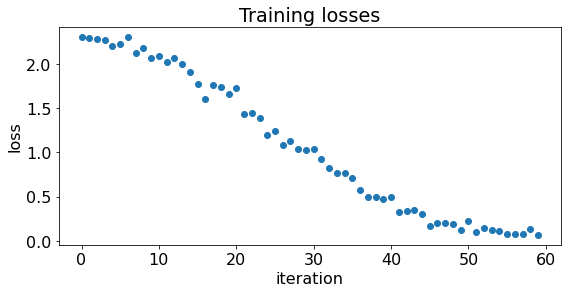

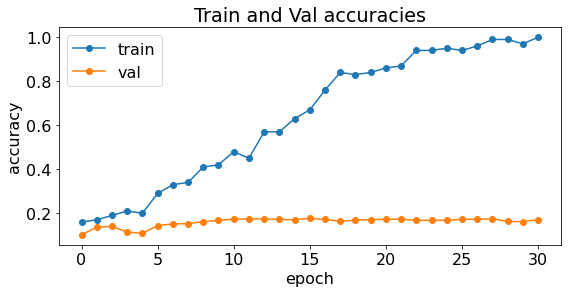

In [ ]:
plt.title('Training losses')
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

plt.title('Train and Val accuracies')
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

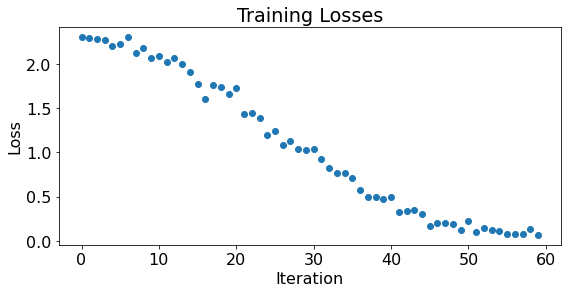

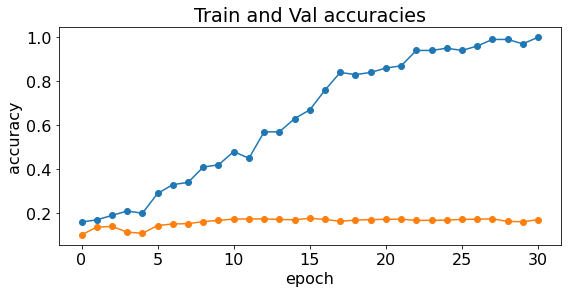

In [ ]:
plt.plot(solver.loss_history, 'o')
plt.title("Training Losses")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.gcf().set_size_inches(9, 4)
plt.show()

plt.title("Train and Val accuracies")
plt.plot(solver.train_acc_history, 'o-', label='train')
plt.plot(solver.val_acc_history, 'o-', label='val')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.gcf().set_size_inches(9, 4)

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 50% accuracy on the training set:

In [ ]:
#from convolutional_networks import ThreeLayerConvNet
#from fully_connected_networks import adam

torch.manual_seed(0)

model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001, dtype=torch.float, device='cuda')

solver = Solver(model, data_dict,
                num_epochs=1, batch_size=64,
                update_rule=adam,
                optim_config={
                  'learning_rate': 2e-3,
                },
                verbose=True, print_every=50, device='cuda')
solver.train()

(Time 0.01 sec; Iteration 1 / 625) loss: 2.306686
(Epoch 0 / 1) train acc: 0.100000; val_acc: 0.093300
(Time 0.36 sec; Iteration 51 / 625) loss: 2.317299
(Time 0.60 sec; Iteration 101 / 625) loss: 2.113615
(Time 0.83 sec; Iteration 151 / 625) loss: 1.814579
(Time 1.08 sec; Iteration 201 / 625) loss: 1.741790
(Time 1.31 sec; Iteration 251 / 625) loss: 1.723384
(Time 1.55 sec; Iteration 301 / 625) loss: 1.711161
(Time 1.80 sec; Iteration 351 / 625) loss: 1.521135
(Time 2.03 sec; Iteration 401 / 625) loss: 1.593427
(Time 2.27 sec; Iteration 451 / 625) loss: 1.587570
(Time 2.50 sec; Iteration 501 / 625) loss: 1.581331
(Time 2.74 sec; Iteration 551 / 625) loss: 1.624608
(Time 2.97 sec; Iteration 601 / 625) loss: 1.570596
(Epoch 1 / 1) train acc: 0.535000; val_acc: 0.497400


## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

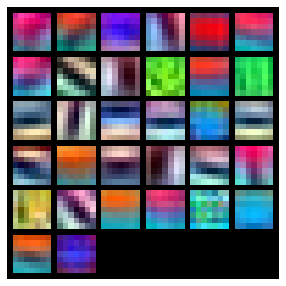

In [ ]:
import math
from torchvision.utils import make_grid
nrow = math.ceil(math.sqrt(model.params['W1'].shape[0]))
grid = make_grid(model.params['W1'], nrow=nrow, padding=1, normalize=True, scale_each=True)
plt.imshow(grid.to(device='cpu').permute(1, 2, 0))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

(-0.5, 55.5, 55.5, -0.5)

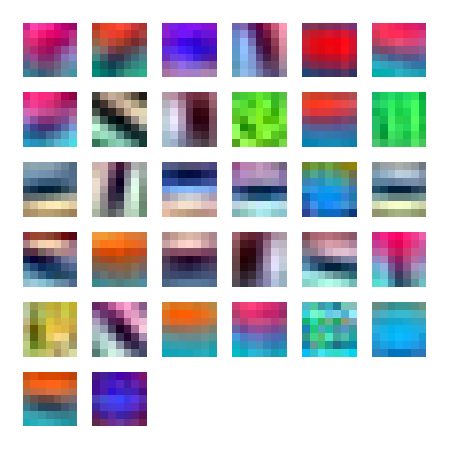

In [ ]:
import math

num_filters_per_row = math.ceil(math.sqrt(model.params['W1'].shape[0]))
filter_grid = torchvision.utils.make_grid(model.params['W1'], nrow=num_filters_per_row, padding=2, normalize=True, scale_each=True, pad_value=1)
plt.imshow(filter_grid.cpu().permute(1, 2, 0))
plt.axis('off')

# Deep convolutional network
Next you will implement a deep convolutional network with an arbitrary number of conv layers in VGGNet style.

Read through the `DeepConvNet` class.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing batch normalization; we will add those features soon. Again, we STRONGLY recommend you to use the fast/sandwich layers (already imported for you) in your implementation.

In [ ]:
class DeepConvNet(object):

  """
  A convolutional neural network with an arbitrary number of convolutional layers in VGG-Net style.

  ######
  All convolutional layers will use kernel_size 3, padding 1, stride 1 to preserve the feature map size.

  All pooling layers will be max pooling layers with 2x2 receptive fields and a stride of 2 to halve
  the size of the feature map.
  ######

  The network will have the following architectures:

  {conv - [batchnorm?] - relu - [pool?]} x (L - 1) - linear

  Each {...} is a "macro layer" consisting of a convolutional layer, an optional batch normalization layer,
  a ReLU nonlinearity, and an optional pooling layer. After L-1 such macro layers, a single fully-connected layer
  is used to predict the class scores.

  The network operates on minibatches of data that have shape (N, C, H, W)
  consisting of N images, each with height H and width W and with C input channels.
  """

  def __init__(self, input_dims=(3, 32, 32),
          num_filters = [8, 8, 8, 8, 8],
          max_pools = [0, 1, 2, 3, 4],
          batchnorm=False,
          num_classes=10, weight_scale=1e-3, reg=0.0,
          weight_initializer=None,
          dtype=torch.float,
          device='cpu'
          ):
    """
    Initialize a new Network.

    Inputs:
    - input_dims: Tuple (C, H, W) giving size of input data;
    - num_filters: List of length (L-1) giving the number of convolutional 
    filters to use in each macro layer.
    - max_pools: List of integers giving the indices of the macro layers that should have max pooling (zero-indexed).
    - batchnorm: Whether to include batch normalization in each macro layer
    - num_classes: Number of scores to produce for the final linear layer.
    - weight_scale: Scalar giving standard deviation for random initialization of weights,
    or the string "kaiming" to use Kaiming initialization method.
    - reg: Scalar giving L2 regularization strength. L2 regularization should only be
    applied to convolutional and fully-connected weight matrices; it should not be applied to 
    biases or to batchnorm scale and shifts.
    - dtype: A torch data dtype object; all computations will be performed using this datatype.
    float is faster but less accurate, so you should use double for numeric gradient checking.
    - device: device to use for computation. 'cpu' or 'cuda'
    """

    self.params = {}
    self.num_layers = len(num_filters) + 1
    self.max_pools = max_pools
    self.batchnorm = batchnorm
    self.reg = reg
    self.dtype = dtype
    if device == 'cuda':
      device = 'cuda:0'
    
    ############################# Initialization ##################################
    C, H, W = input_dims
    for i, F in enumerate(num_filters):
      self.params['W%d' % (i+1)] = weight_scale * torch.randn((F, C, 3, 3), dtype=dtype, device=device)
      self.params['b%d' % (i+1)] = torch.zeros(F, dtype=dtype, device=device)
      C = F
    
    self.H_final = H // 2**(len(max_pools))
    self.W_final = W // 2**(len(max_pools))
    self.params['W%d' % (self.num_layers)] = weight_scale * torch.randn((num_filters[-1]*self.H_final*self.W_final, num_classes), dtype=dtype, device=device)
    self.params['b%d' % (self.num_layers)] = torch.zeros(num_classes, dtype=dtype, device=device)
    #################################################################################

    # With batch normalization we need to keep track of running means and variances,
    # so we need to pass a special 'bn_param' object to each batch normalization layer.
    # You should pass self.bn_params[0] to the forward pass of the first batch normalization layer
    # self.bn_params[1] to the forward pass of the second batch normalization layer, etc.
    self.bn_params = []
    if self.batchnorm:
      self.bn_params = [{'mode': 'train'} for _ in range (len(num_filters))]
    
    # Check that we got the right number of parameters
    if not self.batchnorm:
      params_per_macro_layer = 2 # weight and bias
    else:
      params_per_macro_layer = 4 # weight, bias, scale, shift
    
    num_params = params_per_macro_layer * len(num_filters) + 2 # no batch normalization in the final linear layer
    msg = 'self.params has the wrong number of elements. Got %d; expected %d' % (len(self.params), num_params)
    assert (num_params == len(self.params)), msg

    # Check that all parameters have the correct device and dtype.
    for k, param in self.params.items():
      msg = 'param %s has device %r, should be %r' % (k, param.device, device)
      assert param.device == torch.device(device), msg
      msg = 'param %s has dtype %r, should be %r' % (k, param.dtype, dtype)
      assert param.dtype == dtype, msg
  
  def save(self, path):

    checkpoint = {
        'reg': self.reg,
        'dtype': self.dtype,
        'params': self.params,
        'num_layers': self.num_layers,
        'max_pools': self.max_pools,
        'batchnorm': self.batchnorm,
        'bn_params': self.bn_params,
    }
    torch.save(checkpoint, path)
    print("Saved in {}".format(path))

  def load(self, path, dtype, device):
    checkpoint = torch.load(path, map_location='cpu')
    self.reg = checkpoint['reg']
    self.dtype = checkpoint['dtype']
    self.params = checkpoint['params']
    self.num_layers = checkpoint['num_layers']
    self.max_pools = checkpoint['max_pools']
    self.batchnorm = checkpoint['batchnorm']
    self.bn_params = checkpoint['bn_params']

    for p in self.params:
      self.params[p] = self.params[p].to(device=device, dtype=dtype)
    
    for i in range(len(self.bn_params)):
      for p in ["running_mean", "running_var"]:
        self.bn_params[i][p] = self.bn_params[i][p].to(device=device, dtype=dtype)
    
    print("load checkpoint file: {}".format(path))
  
  def loss(self, X, y=None):
    """
    Evaluate loss and gradient for the deep convolutional network
    Input / output: Same API as ThreeLayerConvNet
    """

    X = X.to(self.dtype)
    mode = 'test' if y is None else 'train'

    # Set train / test mode for batchnorm params since
    # they behave differently during training and testing
    if self.batchnorm:
      for bn_param in self.bn_params:
        bn_param['mode'] = mode
    scores = None

    filter_size = 3
    conv_param = {'stride': 1, 'pad': (filter_size - 1) // 2}
    pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

    scores = None
    #print(self.num_layers)


    out = X.clone()
    cache_conv = {}
    index_pool = 0
    for i in range(1, self.num_layers): # i: [1, 2, 3, 4, ..., 30] max_pools: [9, 19]

      if self.max_pools[index_pool] == i-1: # 0, 1, 2
        out, cache = Conv_ReLU_Pool.forward(out, self.params['W%d'%i], self.params['b%d'%i], conv_param, pool_param)
        cache_conv['macro_layer%d'%i] = cache
        if index_pool + 1 < len(self.max_pools):
          index_pool += 1
      else:
        out, cache = Conv_ReLU.forward(out, self.params['W%d'%i], self.params['b%d'%i], conv_param)
        cache_conv['macro_layer%d'%i] = cache
      #print('Layer: {} ; Conv_out shape {}'.format(i, out.shape))
    #print('Num_layers', self.num_layers)
    #print('H_final: ', self.H_final)
    #print('W_final: ', self.W_final)
      
    scores, cache = Linear.forward(out, self.params['W%d'%(self.num_layers)], self.params['b%d'%(self.num_layers)])

    if y is None:
      return scores
      
    loss, grads = 0, {}

    loss, dout = softmax_loss(scores, y)

    dout, grads['W%d'%(self.num_layers)], grads['b%d'%(self.num_layers)] = Linear.backward(dout, cache)

    index_pool = len(self.max_pools) - 1 # 1
    for i in range(1, self.num_layers): # i: [1, 2, 3, 4, ..., 30] max_pools: [9, 19]
      if self.max_pools[index_pool] == (self.num_layers - i) - 1: # (2, 1, 0)
        dout, grads['W%d'%(self.num_layers-i)], grads['b%d'%(self.num_layers-i)] = Conv_ReLU_Pool.backward(dout, cache_conv['macro_layer%d'%(self.num_layers-i)])
        if index_pool > 0:
          index_pool -= 1
      else:
        dout, grads['W%d'%(self.num_layers-i)], grads['b%d'%(self.num_layers-i)] = Conv_ReLU.backward(dout, cache_conv['macro_layer%d'%(self.num_layers-i)])

    for i in range(1, self.num_layers + 1):
      loss += self.reg * (self.params['W%d'%i]**2).sum()
      grads['W%d'%i] += 2 * self.reg * self.params['W%d'%i]

    return loss, grads

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization the loss should go up slightly.

In [ ]:
#from convolutional_networks import DeepConvNet
#from fully_connected_networks import adam

torch.manual_seed(0)
input_dims = (3, 32, 32)
model = DeepConvNet(num_filters=[8, 64], max_pools=[0, 1], dtype=torch.float64, device='cuda')

N = 50
X = torch.randn(N, *input_dims, dtype=torch.float64, device='cuda')
y = torch.randint(10, size=(N,), dtype=torch.int64, device='cuda')
print(X.shape)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss.item())

model.reg = 1.
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss.item())

torch.Size([50, 3, 32, 32])
Initial loss (no regularization):  2.3025851202631697
Initial loss (with regularization):  2.3482181999566953


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

You should see relative errors less than `1e-5`. 

In [ ]:
#from convolutional_networks import DeepConvNet
#from fully_connected_networks import adam

torch.manual_seed(0)
num_inputs = 2
input_dims = (3, 8, 8)
num_classes = 10
X = torch.randn(N, *input_dims, dtype=torch.float64, device='cuda')
y = torch.randint(10, size=(N,), dtype=torch.int64, device='cuda')

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = DeepConvNet(input_dims=input_dims, num_classes=num_classes,
                      num_filters=[8, 8, 8],
                      max_pools=[0, 2],
                      reg=reg,
                      weight_scale=5e-2, dtype=torch.float64, device='cuda')

  loss, grads = model.loss(X, y)
  # The relative errors should be up to the order of e-6
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eecs598.grad.compute_numeric_gradient(f, model.params[name])
    print('%s max relative error: %e' % (name, eecs598.grad.rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
W1 max relative error: 5.912415e-07
W2 max relative error: 8.190183e-07
W3 max relative error: 5.317616e-07
W4 max relative error: 6.344352e-07
b1 max relative error: 6.956690e-07
b2 max relative error: 4.282076e-07
b3 max relative error: 2.831506e-08
b4 max relative error: 1.407349e-08

Running check with reg =  3.14
W1 max relative error: 7.242144e-09
W2 max relative error: 9.087181e-09
W3 max relative error: 1.289720e-08
W4 max relative error: 7.251152e-09
b1 max relative error: 1.994212e-06
b2 max relative error: 1.289978e-06
b3 max relative error: 4.524272e-07
b4 max relative error: 9.903249e-08


## Overfit small data
As another sanity check, make sure you can overfit a small dataset of 50 images. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 30 epochs.

In [ ]:
def find_overfit_parameters():
  weight_scale = 1e-1
  learning_rate = 1e-3

  return weight_scale, learning_rate

(Time 0.01 sec; Iteration 1 / 150) loss: 2.364212
(Epoch 0 / 30) train acc: 0.020000; val_acc: 0.092600
(Epoch 1 / 30) train acc: 0.140000; val_acc: 0.117400
(Epoch 2 / 30) train acc: 0.160000; val_acc: 0.112000
(Time 0.70 sec; Iteration 11 / 150) loss: 2.276317
(Epoch 3 / 30) train acc: 0.200000; val_acc: 0.110200
(Epoch 4 / 30) train acc: 0.160000; val_acc: 0.095200
(Time 1.16 sec; Iteration 21 / 150) loss: 2.232793
(Epoch 5 / 30) train acc: 0.240000; val_acc: 0.097100
(Epoch 6 / 30) train acc: 0.280000; val_acc: 0.143900
(Time 1.62 sec; Iteration 31 / 150) loss: 2.071779
(Epoch 7 / 30) train acc: 0.480000; val_acc: 0.152800
(Epoch 8 / 30) train acc: 0.540000; val_acc: 0.187300
(Time 2.08 sec; Iteration 41 / 150) loss: 1.900533
(Epoch 9 / 30) train acc: 0.400000; val_acc: 0.173300
(Epoch 10 / 30) train acc: 0.360000; val_acc: 0.169500
(Time 2.53 sec; Iteration 51 / 150) loss: 1.890265
(Epoch 11 / 30) train acc: 0.500000; val_acc: 0.172500
(Epoch 12 / 30) train acc: 0.520000; val_acc:

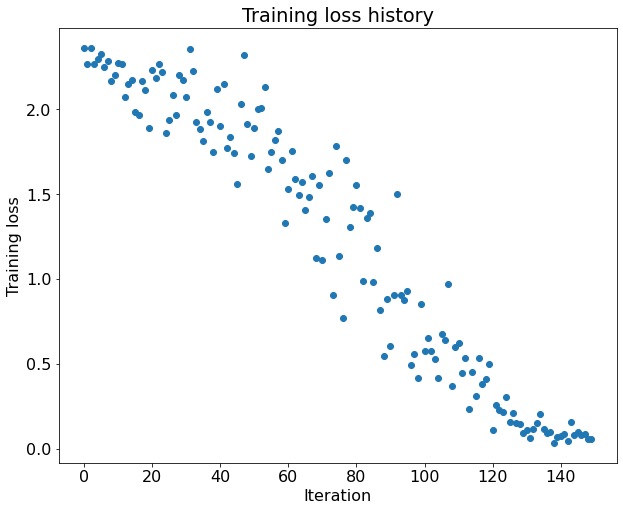

1.0


In [ ]:
# TODO: Use a DeepConvNet to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
# from convolutional_networks import DeepConvNet, find_overfit_parameters
# from fully_connected_networks import adam

torch.manual_seed(0)
num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = small_data['X_train'].shape[1:]


# Update the parameters in find_overfit_parameters in convolutional_networks.py
weight_scale, learning_rate = find_overfit_parameters()


model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[8, 16, 32, 64],
                    max_pools=[0, 1, 2, 3],
                    reg=0, weight_scale=weight_scale, dtype=torch.float32, device='cuda')
solver = Solver(model, small_data,
                print_every=10, num_epochs=30, batch_size=10,
                update_rule=adam,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
# Turn off keep_best_params to allow final weights to be saved, instead of best weights on validation set.
solver.train(return_best_params=False)

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

val_acc = solver.check_accuracy(
                        solver.X_train, solver.y_train, num_samples=solver.num_train_samples
                    )
print(val_acc)

In [ ]:
solver.model.params['W1'].shape

torch.Size([8, 3, 3, 3])

(-0.5, 16.5, 16.5, -0.5)

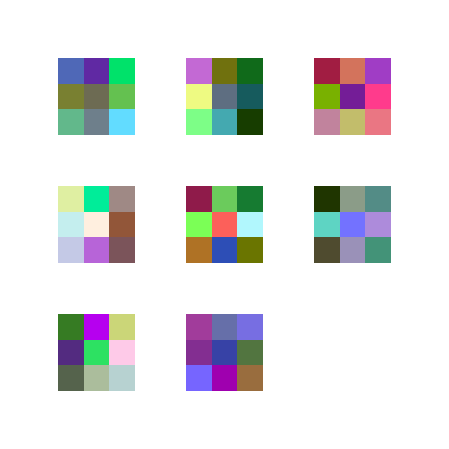

In [ ]:
num_filters_per_row = math.ceil(math.sqrt(solver.model.params['W1'].shape[0]))
img_grid = torchvision.utils.make_grid(solver.model.params['W1'], nrow=num_filters_per_row, normalize=True,
                      scale_each=True, pad_value=1)
plt.imshow(img_grid.cpu().permute(1, 2, 0))
plt.axis('off')


If you're happy with the model's perfromance, run the following cell to save it. 

We will also reload the model and run it on the training data to verify it's the right weights.

In [ ]:
path = os.path.join(GOOGLE_DRIVE_PATH, 'overfit_deepconvnet.pth')
solver.model.save(path)

# Create a new instance
model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[8, 16, 32, 64],
                    max_pools=[0, 1, 2, 3],
                    reg=1e-5, weight_scale=weight_scale, dtype=torch.float32, device='cuda')
solver = Solver(model, small_data,
                print_every=10, num_epochs=30, batch_size=10,
                update_rule=adam,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )


# Load model
solver.model.load(path, dtype=torch.float32, device='cuda')

# Evaluate on validation set
accuracy = solver.check_accuracy(small_data['X_train'], small_data['y_train'])
print(f"Saved model's accuracy on training is {accuracy}")


Saved in drive/My Drive/A3/overfit_deepconvnet.pth
load checkpoint file: drive/My Drive/A3/overfit_deepconvnet.pth
Saved model's accuracy on training is 1.0


# Kaiming initialization
So far, you manually tuned the weight scale and for weight initialization.
However, this is inefficient when it comes to training deep neural networks; practically, as your weight matrix is larger, the weight scale should be small.
Below you will implement [Kaiming initialization](http://arxiv-web3.library.cornell.edu/abs/1502.01852). For more details, refer to [cs231n note](http://cs231n.github.io/neural-networks-2/#init) and [PyTorch documentation](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_).

# Convolutional nets with Kaiming initialization
Now that you have a working implementation for Kaiming initialization, go back to your [`DeepConvnet`](#scrollTo=Ah-_nwx2BSxl). Modify your implementation to add Kaiming initialization.

Concretely, when the `weight_scale` is set to `'kaiming'` in the constructor, you should initialize weights of convolutional and linear layers using `kaiming_initializer`. Once you are done, run the following to see the effect of kaiming initialization in deep CNNs.

In this experiment, we train a 31-layer network with four different weight initialization schemes. Among them, only the Kaiming initialization method should achieve a non-random accuracy after one epoch of training.

You may see `nan` loss when `weight_scale` is large, this shows a catastrophe of inappropriate weight initialization.

In [ ]:
def sgd_momentum(w, dw, config=None):
  """
  Performs SGD + Momentum.

  config format:
  - learning_rate: Scalar learning rate
  - momentum: scalar between 0 and 1 giving momentum value.
   (Setting momentum=0 reduces to SGD)
  - velocity: A torch tensor of the same shape as w and dw, used to
    store a moving average of the gradients.
  """

  if config is None:
    config = {}
  config.setdefault("learning_rate", 1e-2)
  config.setdefault("momentum", 0.9)
  config.setdefault("velocity", torch.zeros_like(w))

  config["velocity"] = config["momentum"] * config["velocity"] - config["learning_rate"] * dw
  w += config["velocity"]

  return w, config

In [ ]:
class DeepConvNet(object):

  """
  A convolutional neural network with an arbitrary number of convolutional layers in VGG-Net style.

  ######
  All convolutional layers will use kernel_size 3, padding 1, stride 1 to preserve the feature map size.

  All pooling layers will be max pooling layers with 2x2 receptive fields and a stride of 2 to halve
  the size of the feature map.
  ######

  The network will have the following architectures:

  {conv - [batchnorm?] - relu - [pool?]} x (L - 1) - linear

  Each {...} is a "macro layer" consisting of a convolutional layer, an optional batch normalization layer,
  a ReLU nonlinearity, and an optional pooling layer. After L-1 such macro layers, a single fully-connected layer
  is used to predict the class scores.

  The network operates on minibatches of data that have shape (N, C, H, W)
  consisting of N images, each with height H and width W and with C input channels.
  """

  def __init__(self, input_dims=(3, 32, 32),
          num_filters = [8, 8, 8, 8, 8],
          max_pools = [0, 1, 2, 3, 4],
          batchnorm=False,
          num_classes=10, weight_scale=1e-3, reg=0.0,
          weight_initializer=None,
          dtype=torch.float,
          device='cpu'
          ):
    """
    Initialize a new Network.

    Inputs:
    - input_dims: Tuple (C, H, W) giving size of input data;
    - num_filters: List of length (L-1) giving the number of convolutional 
    filters to use in each macro layer.
    - max_pools: List of integers giving the indices of the macro layers that should have max pooling (zero-indexed).
    - batchnorm: Whether to include batch normalization in each macro layer
    - num_classes: Number of scores to produce for the final linear layer.
    - weight_scale: Scalar giving standard deviation for random initialization of weights,
    or the string "kaiming" to use Kaiming initialization method.
    - reg: Scalar giving L2 regularization strength. L2 regularization should only be
    applied to convolutional and fully-connected weight matrices; it should not be applied to 
    biases or to batchnorm scale and shifts.
    - dtype: A torch data dtype object; all computations will be performed using this datatype.
    float is faster but less accurate, so you should use double for numeric gradient checking.
    - device: device to use for computation. 'cpu' or 'cuda'
    """

    self.params = {}
    self.num_layers = len(num_filters) + 1
    self.max_pools = max_pools
    self.batchnorm = batchnorm
    self.reg = reg
    self.dtype = dtype
    if device == 'cuda':
      device = 'cuda:0'
    
    ############################# Initialization ##################################

    C, H, W = input_dims
    for i, F in enumerate(num_filters):
      if weight_scale == 'kaiming':
        D_in = (3**2) * C
        std = math.sqrt(2 / D_in)
      else:
        std = weight_scale

      self.params['W%d' % (i+1)] = std * torch.randn((F, C, 3, 3), dtype=dtype, device=device)
      self.params['b%d' % (i+1)] = torch.zeros(F, dtype=dtype, device=device)
      C = F
    
    self.H_final = H // 2**(len(max_pools))
    self.W_final = W // 2**(len(max_pools))
    self.params['W%d' % (self.num_layers)] = std * torch.randn((num_filters[-1]*self.H_final*self.W_final, num_classes), dtype=dtype, device=device)
    self.params['b%d' % (self.num_layers)] = torch.zeros(num_classes, dtype=dtype, device=device)
    #################################################################################

    # With batch normalization we need to keep track of running means and variances,
    # so we need to pass a special 'bn_param' object to each batch normalization layer.
    # You should pass self.bn_params[0] to the forward pass of the first batch normalization layer
    # self.bn_params[1] to the forward pass of the second batch normalization layer, etc.
    self.bn_params = []
    if self.batchnorm:
      self.bn_params = [{'mode': 'train'} for _ in range (len(num_filters))]
    
    # Check that we got the right number of parameters
    if not self.batchnorm:
      params_per_macro_layer = 2 # weight and bias
    else:
      params_per_macro_layer = 4 # weight, bias, scale, shift
    
    num_params = params_per_macro_layer * len(num_filters) + 2 # no batch normalization in the final linear layer
    msg = 'self.params has the wrong number of elements. Got %d; expected %d' % (len(self.params), num_params)
    assert (num_params == len(self.params)), msg

    # Check that all parameters have the correct device and dtype.
    for k, param in self.params.items():
      msg = 'param %s has device %r, should be %r' % (k, param.device, device)
      assert param.device == torch.device(device), msg
      msg = 'param %s has dtype %r, should be %r' % (k, param.dtype, dtype)
      assert param.dtype == dtype, msg
  
  def save(self, path):

    checkpoint = {
        'reg': self.reg,
        'dtype': self.dtype,
        'params': self.params,
        'num_layers': self.num_layers,
        'max_pools': self.max_pools,
        'batchnorm': self.batchnorm,
        'bn_params': self.bn_params,
    }
    torch.save(checkpoint, path)
    print("Saved in {}".format(path))

  def load(self, path, dtype, device):
    checkpoint = torch.load(path, map_location='cpu')
    self.reg = checkpoint['reg']
    self.dtype = checkpoint['dtype']
    self.params = checkpoint['params']
    self.num_layers = checkpoint['num_layers']
    self.max_pools = checkpoint['max_pools']
    self.batchnorm = checkpoint['batchnorm']
    self.bn_params = checkpoint['bn_params']

    for p in self.params:
      self.params[p] = self.params[p].to(device=device, dtype=dtype)
    
    for i in range(len(self.bn_params)):
      for p in ["running_mean", "running_var"]:
        self.bn_params[i][p] = self.bn_params[i][p].to(device=device, dtype=dtype)
    
    print("load checkpoint file: {}".format(path))
  
  def loss(self, X, y=None):
    """
    Evaluate loss and gradient for the deep convolutional network
    Input / output: Same API as ThreeLayerConvNet
    """

    X = X.to(self.dtype)
    mode = 'test' if y is None else 'train'

    # Set train / test mode for batchnorm params since
    # they behave differently during training and testing
    if self.batchnorm:
      for bn_param in self.bn_params:
        bn_param['mode'] = mode
    scores = None

    filter_size = 3
    conv_param = {'stride': 1, 'pad': (filter_size - 1) // 2}
    pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

    scores = None
    #print(self.num_layers)


    out = X.clone()
    cache_conv = {}
    index_pool = 0
    for i in range(1, self.num_layers): # i: [1, 2, 3, 4, ..., 30] max_pools: [9, 19]

      if self.max_pools[index_pool] == i-1: # 0, 1, 2
        out, cache = Conv_ReLU_Pool.forward(out, self.params['W%d'%i], self.params['b%d'%i], conv_param, pool_param)
        cache_conv['macro_layer%d'%i] = cache
        if index_pool + 1 < len(self.max_pools):
          index_pool += 1
      else:
        out, cache = Conv_ReLU.forward(out, self.params['W%d'%i], self.params['b%d'%i], conv_param)
        cache_conv['macro_layer%d'%i] = cache
      #print('Layer: {} ; Conv_out shape {}'.format(i, out.shape))
    #print('Num_layers', self.num_layers)
    #print('H_final: ', self.H_final)
    #print('W_final: ', self.W_final)
      
    scores, cache = Linear.forward(out, self.params['W%d'%(self.num_layers)], self.params['b%d'%(self.num_layers)])

    if y is None:
      return scores
      
    loss, grads = 0, {}

    loss, dout = softmax_loss(scores, y)

    dout, grads['W%d'%(self.num_layers)], grads['b%d'%(self.num_layers)] = Linear.backward(dout, cache)

    index_pool = len(self.max_pools) - 1 # 1
    for i in range(1, self.num_layers): # i: [1, 2, 3, 4, ..., 30] max_pools: [9, 19]
      if self.max_pools[index_pool] == (self.num_layers - i) - 1: # (2, 1, 0)
        dout, grads['W%d'%(self.num_layers-i)], grads['b%d'%(self.num_layers-i)] = Conv_ReLU_Pool.backward(dout, cache_conv['macro_layer%d'%(self.num_layers-i)])
        if index_pool > 0:
          index_pool -= 1
      else:
        dout, grads['W%d'%(self.num_layers-i)], grads['b%d'%(self.num_layers-i)] = Conv_ReLU.backward(dout, cache_conv['macro_layer%d'%(self.num_layers-i)])

    for i in range(1, self.num_layers + 1):
      loss += self.reg * (self.params['W%d'%i]**2).sum()
      grads['W%d'%i] += 2 * self.reg * self.params['W%d'%i]

    return loss, grads

In [ ]:
#from convolutional_networks import DeepConvNet
#from fully_connected_networks import sgd_momentum
torch.manual_seed(0)

# Try training a deep convolutional net with different weight initialization methods
num_train = 10000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]

weight_scales = ['kaiming', 1e-1, 1e-2, 1e-3]

solvers = []
for weight_scale in weight_scales:
  print('Solver with weight scale: ', weight_scale)
  model = DeepConvNet(input_dims=input_dims, num_classes=10,
                      num_filters=([8] * 10) + ([32] * 10) + ([128] * 10),
                      max_pools=[9, 19],
                      weight_scale=weight_scale,
                      reg=1e-5, 
                      dtype=torch.float32,
                      device='cuda'
                      )

  solver = Solver(model, small_data,
                  num_epochs=1, batch_size=128,
                  update_rule=sgd_momentum,
                  optim_config={
                    'learning_rate': 2e-3,
                  },
                  print_every=20, device='cuda')
  solver.train()
  solvers.append(solver)

Solver with weight scale:  kaiming
(Time 0.05 sec; Iteration 1 / 78) loss: 2.636280
(Epoch 0 / 1) train acc: 0.107000; val_acc: 0.105500
(Time 3.13 sec; Iteration 21 / 78) loss: 2.334605
(Time 4.04 sec; Iteration 41 / 78) loss: 2.332467
(Time 4.95 sec; Iteration 61 / 78) loss: 2.263186
(Epoch 1 / 1) train acc: 0.192000; val_acc: 0.183500
Solver with weight scale:  0.1
(Time 0.05 sec; Iteration 1 / 78) loss: 82.162605
(Epoch 0 / 1) train acc: 0.095000; val_acc: 0.097700
(Time 3.15 sec; Iteration 21 / 78) loss: nan
(Time 4.06 sec; Iteration 41 / 78) loss: nan
(Time 4.98 sec; Iteration 61 / 78) loss: nan
(Epoch 1 / 1) train acc: 0.092000; val_acc: 0.101400
Solver with weight scale:  0.01
(Time 0.04 sec; Iteration 1 / 78) loss: 2.304123
(Epoch 0 / 1) train acc: 0.120000; val_acc: 0.100300
(Time 3.14 sec; Iteration 21 / 78) loss: 2.304193
(Time 4.04 sec; Iteration 41 / 78) loss: 2.303957
(Time 4.95 sec; Iteration 61 / 78) loss: 2.303860
(Epoch 1 / 1) train acc: 0.111000; val_acc: 0.100300
S

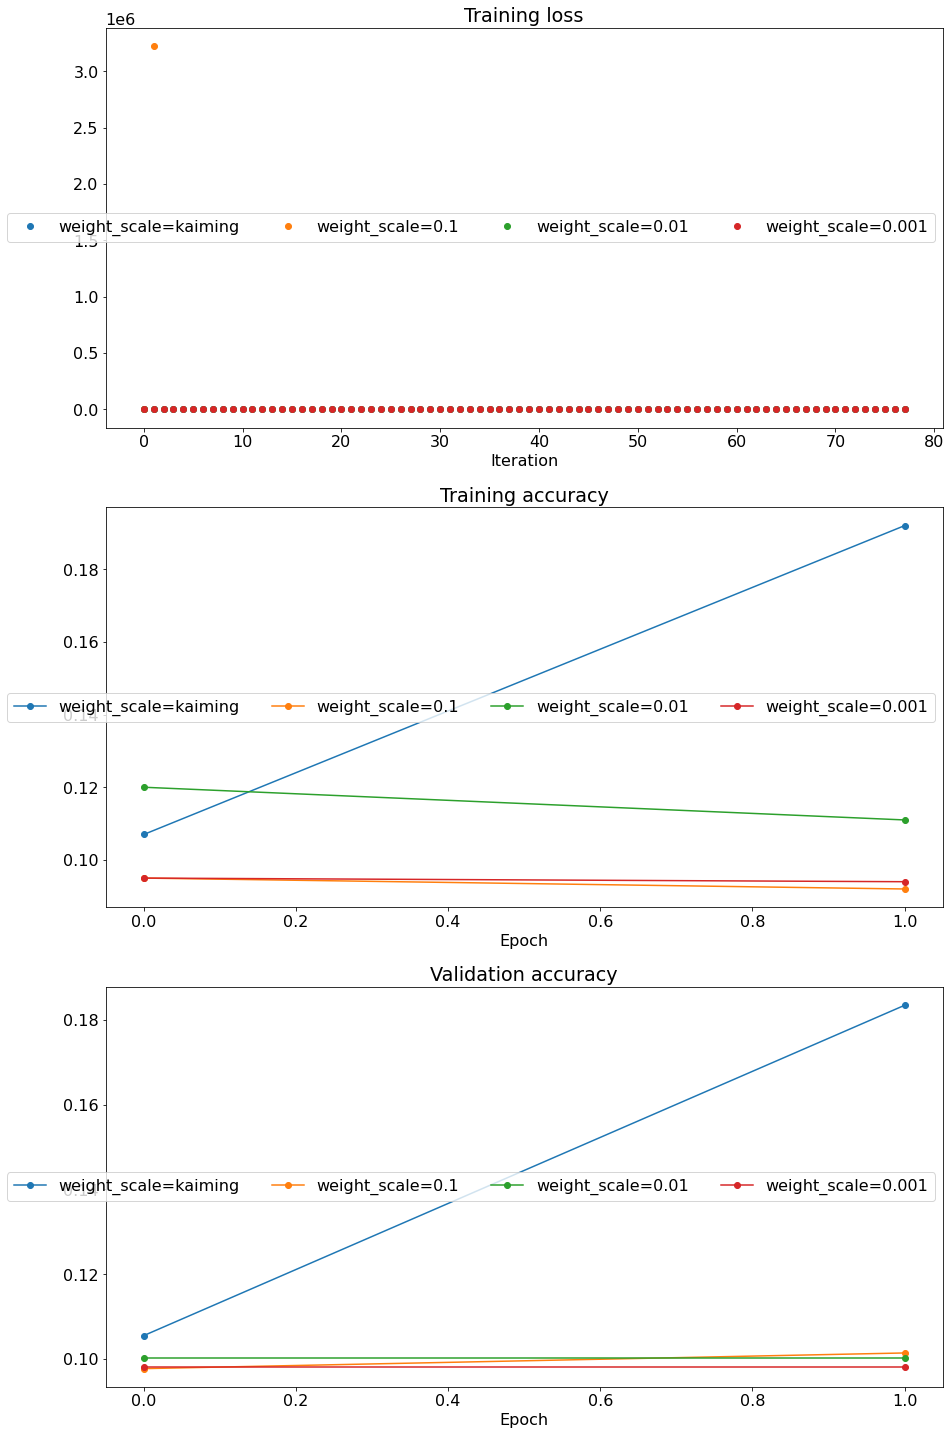

In [ ]:
def plot_training_history_init(title, xlabel, solvers, labels, plot_fn, marker='-o'):
  plt.title(title)
  plt.xlabel(xlabel)
  for solver, label in zip(solvers, labels):    
    data = plot_fn(solver) # solver.loss_history
    label = 'weight_scale=' + str(label)
    plt.plot(data, marker, label=label)
  plt.legend(ncol=len(solvers))

plt.subplot(3, 1, 1)
plot_training_history_init('Training loss','Iteration', solvers, weight_scales,
                            lambda x: x.loss_history, marker='o')
plt.subplot(3, 1, 2)
plot_training_history_init('Training accuracy','Epoch', solvers, weight_scales,
                           lambda x: x.train_acc_history)
plt.subplot(3, 1, 3)
plot_training_history_init('Validation accuracy','Epoch', solvers, weight_scales,
                           lambda x: x.val_acc_history)
plt.gcf().set_size_inches(15, 25)
plt.show()

# Train a good model!
Train the best convolutional model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 71% accuracy on the validation set using a convolutional net, within 60 seconds of training.

You might find it useful to use batch normalization in your model. However, since we do not ask you to implement it CUDA-friendly, it might slow down training. 

**Implement** `create_convolutional_solver_instance` while making sure to use the initialize your model with the input `dtype` and `device`, as well as initializing the solver on the input `device`. 

Hint: Your model does not have to be too deep.

Hint 2: We used `batch_size = 128` for training a model with 74% validation accuracy. You don't have to follow this, but it would save your time for hyperparameter search.

Hint 3: Note that we import all the functions from fully_connected_networks, so feel free to use the optimizers you've already imolemented; e.g., adam. 

In [ ]:
def create_convolutional_solver_instance(data_dict, dtype, device):

  input_dims = data_dict['X_train'].shape[1:]
  model = DeepConvNet(input_dims=input_dims,
             num_filters=[8]*2 + [32]*4 + [64]*4,
             max_pools=[1, 5, 9],
             batchnorm=False,
             num_classes=10,
             weight_scale='kaiming',
             reg=6e-4,
             weight_initializer=None,
             dtype=dtype,
             device=device
             )
  
  solver = Solver(model, data_dict,
           update_rule=adam,
           optim_config={'learning_rate': 2e-3,},
           lr_decay=0.88,
           batch_size=128,
           num_epochs=100,
           device='cuda',
           print_every=1000,
           )

  return solver


In [ ]:
#from convolutional_networks import DeepConvNet, create_convolutional_solver_instance

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

solver = create_convolutional_solver_instance(data_dict, torch.float32, "cuda")

solver.train(time_limit=60)

torch.backends.cudnn.benchmark = False

(Time 0.02 sec; Iteration 1 / 31200) loss: 2.816758
(Epoch 0 / 100) train acc: 0.109000; val_acc: 0.102500
(Epoch 1 / 100) train acc: 0.502000; val_acc: 0.497000
(Epoch 2 / 100) train acc: 0.573000; val_acc: 0.556600
(Epoch 3 / 100) train acc: 0.629000; val_acc: 0.613900
(Time 16.45 sec; Iteration 1001 / 31200) loss: 1.299811
(Epoch 4 / 100) train acc: 0.660000; val_acc: 0.638000
(Epoch 5 / 100) train acc: 0.730000; val_acc: 0.664200
(Epoch 6 / 100) train acc: 0.732000; val_acc: 0.684000
(Time 32.33 sec; Iteration 2001 / 31200) loss: 0.918449
(Epoch 7 / 100) train acc: 0.733000; val_acc: 0.704300
(Epoch 8 / 100) train acc: 0.752000; val_acc: 0.701300
(Epoch 9 / 100) train acc: 0.788000; val_acc: 0.709900
(Time 48.19 sec; Iteration 3001 / 31200) loss: 0.961213
(Epoch 10 / 100) train acc: 0.785000; val_acc: 0.721200
(Epoch 11 / 100) train acc: 0.814000; val_acc: 0.725800
(Epoch 12 / 100) train acc: 0.857000; val_acc: 0.735900
(Time 60.36 sec; Iteration 3744 / 31200) loss: 0.782636
End of

# Test your model!
Run your best model on the validation and test sets. You should achieve above 71% accuracy on the validation set and 70% accuracy on the test set.

(Our best model gets 74.3% validation accuracy and 73.5% test accuracy -- can you beat ours?)


In [ ]:
print('Validation set accuracy: ', solver.check_accuracy(data_dict['X_val'], data_dict['y_val']))
print('Test set accuracy: ', solver.check_accuracy(data_dict['X_test'], data_dict['y_test']))

Validation set accuracy:  0.7358999848365784
Test set accuracy:  0.7318999767303467


If you're happy with the model's perfromance, run the following cell to save it. 

We will also reload the model and run it on the training data to verify it's the right weights.

In [ ]:
path = os.path.join(GOOGLE_DRIVE_PATH, 'one_minute_deepconvnet.pth')
solver.model.save(path)

# Create a new instance
# from convolutional_networks import DeepConvNet, create_convolutional_solver_instance

solver = create_convolutional_solver_instance(data_dict, torch.float32, "cuda")

# Load model
solver.model.load(path, dtype=torch.float32, device='cuda')

# Evaluate on validation set
print('Validation set accuracy: ', solver.check_accuracy(data_dict['X_val'], data_dict['y_val']))
print('Test set accuracy: ', solver.check_accuracy(data_dict['X_test'], data_dict['y_test']))

Saved in drive/My Drive/A3/one_minute_deepconvnet.pth
load checkpoint file: drive/My Drive/A3/one_minute_deepconvnet.pth
Validation set accuracy:  0.7358999848365784
Test set accuracy:  0.7318999767303467


# Batch Normalization
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. 
One idea along these lines is batch normalization which was proposed by [1] in 2015.

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However, even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [1] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [1] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

## Batch normalization: forward
Implement the batch normalization forward pass in the function `BatchNorm.forward`. Once you have done so, run the following to test your implementation.

Referencing the paper linked to above in [1] may be helpful!

After implementing the forward pass for batch normalization, you can run the following to sanity check your implementation. After running batch normalization with beta=0 and gamma=1, the data should have zero mean and unit variance.

After running batch normalization with nontrivial beta and gamma, the output data should have mean approximately equal to beta, and std approximatly equal to gamma.

In [ ]:
class BatchNorm(object):

  @staticmethod
  def forward(x, gamma, beta, bn_param):

    """
    Forward pass for batch normalization.

    ######################### Training Time ############################################
    During training, the sample mean and (uncorrected sample variance) are
    computed from minibatch statistics and used to normalize the incoming data.

    During training, we also keep and exponentially decaying running mean of
    the mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep, we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var
    #######################################################################################

    ######################## Test Time #################################################
    Note that the batch normalization paper suggests a different test-time behavior:
    they compute sample mean and variance for each feature using a large number of training
    images rather than using a running average.

    For this implementation, we have chosen to use running averages instead since
    they do not require an additional estimation step; the PyTorch implementation of batch
    normalization also uses running average.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift parameter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability;
      - momentum: Constant for running mean / variance;
      - running_mean: Array of shape (D,) giving running mean of features;
      - running_var: Array of shape (D,) giving running variance of features
    
    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """

    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', torch.zeros(D, dtype=x.dtype, device=x.device))
    running_var = bn_param.get('running_var', torch.zeros(D, dtype=x.dtype, device=x.device))

    out, cache = None, None
    if mode == 'train':
      # Conduct batch normalization
      sample_mean = x.mean(dim=0, dtype=x.dtype) # (D,)
      sample_var = x.var(dim=0, unbiased=False) # (D,) Without Bessel's correction
      x_bn = (x - sample_mean) / (sample_var + eps).sqrt() # (N, D) eps for stability
      out = gamma * x_bn + beta

      # Keep track of exponentially running average of mean and variance
      running_mean = momentum * running_mean + (1 - momentum) * sample_mean # (D,)
      running_var = momentum * running_var + (1 - momentum) * sample_var # (D,)

      cache = x, x_bn, sample_mean, sample_var, running_mean, running_var
    
    elif mode == 'test':
      x_bn = (x - running_mean) / (running_var + eps).sqrt() # (N, D)
      out = gamma * x_bn + beta

      cache = x, x_bn
    
    else:
      raise ValueError('Invalid forward batchnorm mode "%s' % mode)
    
    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean.detach()
    bn_param['running_var'] = running_var.detach()

    return out, cache

In [ ]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization
#from convolutional_networks import BatchNorm

def print_mean_std(x,dim=0):
  means = ['%.3f' % xx for xx in x.mean(dim=dim).tolist()]
  stds = ['%.3f' % xx for xx in x.std(dim=dim).tolist()]
  print('  means: ', means)
  print('  stds:  ', stds)
  print()

# Simulate the forward pass for a two-layer network
torch.manual_seed(0)
N, D1, D2, D3 = 200, 50, 60, 3
X = torch.randn(N, D1, dtype=torch.float64, device='cuda')
W1 = torch.randn(D1, D2, dtype=torch.float64, device='cuda')
W2 = torch.randn(D2, D3, dtype=torch.float64, device='cuda')
a = X.matmul(W1).clamp(min=0.).matmul(W2)

print('Before batch normalization:')
print_mean_std(a,dim=0)

# Run with gamma=1, beta=0. Means should be close to zero and stds close to one
gamma = torch.ones(D3, dtype=torch.float64, device='cuda')
beta = torch.zeros(D3, dtype=torch.float64, device='cuda')
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = BatchNorm.forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,dim=0)

# Run again with nontrivial gamma and beta. Now means should be close to beta
# and std should be close to gamma.
gamma = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float64, device='cuda')
beta = torch.tensor([11.0, 12.0, 13.0], dtype=torch.float64, device='cuda')
print('After batch normalization (gamma=', gamma.tolist(), ', beta=', beta.tolist(), ')')
a_norm, _ = BatchNorm.forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,dim=0)

Before batch normalization:
  means:  ['52.046', '11.122', '10.243']
  stds:   ['34.646', '30.732', '39.429']

After batch normalization (gamma=1, beta=0)
  means:  ['-0.000', '-0.000', '0.000']
  stds:   ['1.003', '1.003', '1.003']

After batch normalization (gamma= [1.0, 2.0, 3.0] , beta= [11.0, 12.0, 13.0] )
  means:  ['11.000', '12.000', '13.000']
  stds:   ['1.003', '2.005', '3.008']



We can sanity-check the test-time forward pass of batch normalization by running the following. First we run the training-time forward pass many times to "warm up" the running averages. If we then run a test-time forward pass, the output should have approximately zero mean and unit variance.

In [ ]:
#from convolutional_networks import BatchNorm

torch.manual_seed(0)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = torch.randn(D1, D2, dtype=torch.float64, device='cuda')
W2 = torch.randn(D2, D3, dtype=torch.float64, device='cuda')

bn_param = {'mode': 'train'}
gamma = torch.ones(D3, dtype=torch.float64, device='cuda') # std: [1.0, 1.0, 1.0]
beta = torch.zeros(D3, dtype=torch.float64, device='cuda') # mean：[0.0, 0.0, 0.0]

for t in range(500):
  X = torch.randn(N, D1, dtype=torch.float64, device='cuda')
  a = X.matmul(W1).clamp(min=0.).matmul(W2)
  BatchNorm.forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = torch.randn(N, D1, dtype=torch.float64, device='cuda')
a = X.matmul(W1).clamp(min=0.).matmul(W2)
a_norm, _ = BatchNorm.forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,dim=0)

After batch normalization (test-time):
  means:  ['0.031', '-0.051', '0.061']
  stds:   ['1.011', '0.958', '1.068']



## Batch normalization: backward
Now implement the backward pass for batch normalization in the function `BatchNorm.backward`.

To derive the backward pass you should write out the computation graph for batch normalization and backprop through each of the intermediate nodes. Some intermediates may have multiple outgoing branches; make sure to sum gradients across these branches in the backward pass.

Please don't forget to implement the train and test mode separately.

Once you have finished, run the following to numerically check your backward pass.

In [ ]:
class BatchNorm(object):

  @staticmethod
  def forward(x, gamma, beta, bn_param):

    """
    Forward pass for batch normalization.

    ######################### Training Time ############################################
    During training, the sample mean and (uncorrected sample variance) are
    computed from minibatch statistics and used to normalize the incoming data.

    During training, we also keep and exponentially decaying running mean of
    the mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep, we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var
    #######################################################################################

    ######################## Test Time #################################################
    Note that the batch normalization paper suggests a different test-time behavior:
    they compute sample mean and variance for each feature using a large number of training
    images rather than using a running average.

    For this implementation, we have chosen to use running averages instead since
    they do not require an additional estimation step; the PyTorch implementation of batch
    normalization also uses running average.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift parameter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability;
      - momentum: Constant for running mean / variance;
      - running_mean: Array of shape (D,) giving running mean of features;
      - running_var: Array of shape (D,) giving running variance of features
    
    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """

    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', torch.zeros(D, dtype=x.dtype, device=x.device))
    running_var = bn_param.get('running_var', torch.zeros(D, dtype=x.dtype, device=x.device))

    out, cache = None, None
    if mode == 'train':
      # Conduct batch normalization
      sample_mean = x.mean(dim=0, dtype=x.dtype) # (D,)
      sample_var = x.var(dim=0, unbiased=False) # (D,) Without Bessel's correction
      x_bn = (x - sample_mean) / (sample_var + eps).sqrt() # (N, D) eps for stability
      #print(gamma.shape)
      #print(beta.shape)
      #print(x_bn.shape)
      out = gamma * x_bn + beta


      # Keep track of exponentially running average of mean and variance
      running_mean = momentum * running_mean + (1 - momentum) * sample_mean # (D,)
      running_var = momentum * running_var + (1 - momentum) * sample_var # (D,)

      cache = x, x_bn, sample_mean, sample_var, gamma, beta, eps
    
    elif mode == 'test':
      x_bn = (x - running_mean) / (running_var + eps).sqrt() # (N, D)
      out = gamma * x_bn + beta

      cache = x, x_bn
    
    else:
      raise ValueError('Invalid forward batchnorm mode "%s' % mode)
    
    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean.detach()
    bn_param['running_var'] = running_var.detach()

    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for batch normalization.

    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from BatchNorm.forward()

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """

    dx, dgamma, dbeta = None, None, None

    x, x_bn, mu, var, gamma, beta, eps = cache

    m = x.shape[0]

    # backpropagation of Scale and Shift
    dgamma = (x_bn * dout).sum(dim=0) # (D,)

    dbeta = dout.sum(dim=0) # (D,)

    # backpropagation of dL/dx

    dx_bn = dout * gamma # (N, D) = (N, D) * (D,)

    dvar = (dx_bn * (x - mu) * (-1/2) * (var + eps)**(-3/2)).sum(dim=0) # (D,)

    dmu = (- dx_bn / (var+eps).sqrt()).sum(dim=0) + dvar * (1/m) * (-2 * (x - mu).sum(dim=0))

    dx = dx_bn / (var+eps).sqrt() + dvar * 2 * (x - mu) * (1/m) + dmu * (1/m)

    return dx, dgamma, dbeta

In [ ]:
#from convolutional_networks import BatchNorm

# Gradient check batchnorm backward pass
torch.manual_seed(0)
N, D = 4, 5
x = 5 * torch.randn(N, D, dtype=torch.float64, device='cuda') + 12
gamma = torch.randn(D, dtype=torch.float64, device='cuda')
beta = torch.randn(D, dtype=torch.float64, device='cuda')
dout = torch.randn(N, D, dtype=torch.float64, device='cuda')

bn_param = {'mode': 'train'}
fx = lambda x: BatchNorm.forward(x, gamma, beta, bn_param)[0]
fg = lambda a: BatchNorm.forward(x, a, beta, bn_param)[0]
fb = lambda b: BatchNorm.forward(x, gamma, b, bn_param)[0]

dx_num = eecs598.grad.compute_numeric_gradient(fx, x, dout)
da_num = eecs598.grad.compute_numeric_gradient(fg, gamma.clone(), dout)
db_num = eecs598.grad.compute_numeric_gradient(fb, beta.clone(), dout)

_, cache = BatchNorm.forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = BatchNorm.backward(dout, cache)
# You should expect to see relative errors between 1e-12 and 1e-9
print('dx error: ', eecs598.grad.rel_error(dx_num, dx))
print('dgamma error: ', eecs598.grad.rel_error(da_num, dgamma))
print('dbeta error: ', eecs598.grad.rel_error(db_num, dbeta))

dx error:  9.592374157140165e-09
dgamma error:  4.765758100649042e-10
dbeta error:  2.919336030277982e-10


## Batch normalization: alternative backward (My above implementation is same as this one)
In class we talked about two different implementations for the sigmoid backward pass. One strategy is to write out a computation graph composed of simple operations and backprop through all intermediate values. Another strategy is to work out the derivatives on paper. For example, you can derive a very simple formula for the sigmoid function's backward pass by simplifying gradients on paper.

Surprisingly, it turns out that you can do a similar simplification for the batch normalization backward pass too!  

In the forward pass, given a set of inputs $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$, 

we first calculate the mean $\mu$ and variance $v$.
With $\mu$ and $v$ calculated, we can calculate the standard deviation $\sigma$  and normalized data $Y$.
The equations and graph illustration below describe the computation ($y_i$ is the i-th element of the vector $Y$).

\begin{align}
& \mu=\frac{1}{N}\sum_{k=1}^N x_k  &  v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2 \\
& \sigma=\sqrt{v+\epsilon}         &  y_i=\frac{x_i-\mu}{\sigma}
\end{align}

<img src="https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a3/batchnorm_graph.png" width=691 height=202>

The meat of our problem during backpropagation is to compute $\frac{\partial L}{\partial X}$, given the upstream gradient we receive, $\frac{\partial L}{\partial Y}.$ To do this, recall the chain rule in calculus gives us $\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot \frac{\partial Y}{\partial X}$.

The unknown/hart part is $\frac{\partial Y}{\partial X}$. We can find this by first deriving step-by-step our local gradients at 
$\frac{\partial v}{\partial X}$, $\frac{\partial \mu}{\partial X}$,
$\frac{\partial \sigma}{\partial v}$, 
$\frac{\partial Y}{\partial \sigma}$, and $\frac{\partial Y}{\partial \mu}$,
and then use the chain rule to compose these gradients (which appear in the form of vectors!) appropriately to compute $\frac{\partial Y}{\partial X}$.

If it's challenging to directly reason about the gradients over $X$ and $Y$ which require matrix multiplication, try reasoning about the gradients in terms of individual elements $x_i$ and $y_i$ first: in that case, you will need to come up with the derivations for $\frac{\partial L}{\partial x_i}$, by relying on the Chain Rule to first calculate the intermediate $\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$ then assemble these pieces to calculate $\frac{\partial y_i}{\partial x_i}$. 

You should make sure each of the intermediary gradient derivations are all as simplified as possible, for ease of implementation. 

After doing so, implement the simplified batch normalization backward pass in the function `BatchNorm.backward_alt` and compare the two implementations by running the following. Your two implementations should compute nearly identical results, but the alternative implementation should be a bit faster.

In [ ]:
from convolutional_networks import BatchNorm

reset_seed(0)
N, D = 128, 2048
x = 5 * torch.randn(N, D, dtype=torch.float64, device='cuda') + 12
gamma = torch.randn(D, dtype=torch.float64, device='cuda')
beta = torch.randn(D, dtype=torch.float64, device='cuda')
dout = torch.randn(N, D, dtype=torch.float64, device='cuda')

bn_param = {'mode': 'train'}
out, cache = BatchNorm.forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = BatchNorm.backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = BatchNorm.backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', eecs598.grad.rel_error(dx1, dx2))
print('dgamma difference: ', eecs598.grad.rel_error(dgamma1, dgamma2))
print('dbeta difference: ', eecs598.grad.rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

# Spatial Batch Normalization
As proposed in the original paper, batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect every feature channel's statistics e.g. mean, variance to be relatively consistent both between different images, and different locations within the same image -- after all, every feature channel is produced by the same convolutional filter! Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over the minibatch dimension `N` as well the spatial dimensions `H` and `W`.


[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

## Spatial batch normalization: forward

Implement the forward pass for spatial batch normalization in the function `SpatialBatchNorm.forward`. Check your implementation by running the following:

In [ ]:
class SpatialBatchNorm(object):

  @staticmethod
  def forward(x, gamma, beta, bn_param):
    """
    Computes the forward pass for spatial batch normalization.

    Inputs:
    - x: Input data of shape (N, C, H, W)
    - gamma: Scale parameter, of shape (C,)
    - beta: Shift parameter, of shape (C,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test; REQUIRED
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance. momentum=0 means
      that old information is discarded completely at every time step, while
      momentum=1 means that new information is never incorporated. The default
      momentum=0.9 should work well in most situations.
      - running_mean: Array of shape (C,) giving running mean of features.
      - running_var: Array of shape (C,) giving running variance of features.
    
    Returns a tuple of:
    - out: Output data, of shape (N, C, H, W)
    - cache: Values needed for the backward pass
    """
    N, C, H, W = x.shape
    x_vanilla = x.permute(0, 2, 3, 1).reshape(-1, C) # (N, H, W, C) -> (N*H*W, C)
    out, cache = BatchNorm.forward(x_vanilla, gamma, beta, bn_param) # (N*H*W, C)
    out = out.reshape(N, H, W, C).permute(0, 3, 1, 2)

    return out, cache



After implementing the forward pass for spatial batch normalization, you can run the following to sanity check your code.

In [ ]:
#from convolutional_networks import SpatialBatchNorm

torch.manual_seed(0)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * torch.randn(N, C, H, W, dtype=torch.float64, device='cuda') + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(dim=(0, 2, 3)))
print('  Stds: ', x.std(dim=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma = torch.ones(C, dtype=torch.float64, device='cuda')
beta = torch.zeros(C,dtype=torch.float64, device='cuda')
bn_param = {'mode': 'train'}
out, _ = SpatialBatchNorm.forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(dim=(0, 2, 3)))
print('  Stds: ', out.std(dim=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma = torch.tensor([3, 4, 5], dtype=torch.float64, device='cuda')
beta = torch.tensor([6, 7, 8], dtype=torch.float64, device='cuda')
out, _ = SpatialBatchNorm.forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(dim=(0, 2, 3)))
print('  Stds: ', out.std(dim=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  torch.Size([2, 3, 4, 5])
  Means:  tensor([ 9.5501, 10.2173,  9.8379], device='cuda:0', dtype=torch.float64)
  Stds:  tensor([3.9212, 4.7963, 3.6011], device='cuda:0', dtype=torch.float64)
After spatial batch normalization:
  Shape:  torch.Size([2, 3, 4, 5])
  Means:  tensor([-2.2204e-16,  1.9706e-16, -2.1094e-16], device='cuda:0',
       dtype=torch.float64)
  Stds:  tensor([1.0127, 1.0127, 1.0127], device='cuda:0', dtype=torch.float64)
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  torch.Size([2, 3, 4, 5])
  Means:  tensor([6., 7., 8.], device='cuda:0', dtype=torch.float64)
  Stds:  tensor([3.0382, 4.0510, 5.0637], device='cuda:0', dtype=torch.float64)


Similar to the vanilla batch normalization implementation, run the following to sanity-check the test-time forward pass of spatial batch normalization.

In [ ]:
torch.manual_seed(0)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = torch.ones(C, dtype=torch.float64, device='cuda')
beta = torch.zeros(C, dtype=torch.float64, device='cuda')
for t in range(50):
  x = 2.3 * torch.randn(N, C, H, W, dtype=torch.float64, device='cuda') + 13
  SpatialBatchNorm.forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * torch.randn(N, C, H, W, dtype=torch.float64, device='cuda') + 13
a_norm, _ = SpatialBatchNorm.forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(dim=(0, 2, 3)))
print('  stds: ', a_norm.std(dim=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  tensor([0.0188, 0.0145, 0.0422, 0.0231], device='cuda:0', dtype=torch.float64)
  stds:  tensor([0.9861, 1.0143, 1.0138, 0.9916], device='cuda:0', dtype=torch.float64)


## Spatial batch normalization: backward
Implement the backward pass for spatial batch normalization in the function `SpatialBatchNorm.backward`.

After implementing the backward pass for spatial batch normalization, run the following to perform numeric gradient checking on your implementation. You should see errors less than `1e-6`.

In [ ]:
class SpatialBatchNorm(object):

  @staticmethod
  def forward(x, gamma, beta, bn_param):
    """
    Computes the forward pass for spatial batch normalization.

    Inputs:
    - x: Input data of shape (N, C, H, W)
    - gamma: Scale parameter, of shape (C,)
    - beta: Shift parameter, of shape (C,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test; REQUIRED
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance. momentum=0 means
      that old information is discarded completely at every time step, while
      momentum=1 means that new information is never incorporated. The default
      momentum=0.9 should work well in most situations.
      - running_mean: Array of shape (C,) giving running mean of features.
      - running_var: Array of shape (C,) giving running variance of features.
    
    Returns a tuple of:
    - out: Output data, of shape (N, C, H, W)
    - cache: Values needed for the backward pass
    """
    N, C, H, W = x.shape
    x_vanilla = x.permute(0, 2, 3, 1).reshape(-1, C) # (N, H, W, C) -> (N*H*W, C)
    #print("x_vanilla.shape: ", x_vanilla.shape)
    out, cache = BatchNorm.forward(x_vanilla, gamma, beta, bn_param) # (N*H*W, C)
    out = out.reshape(N, H, W, C).permute(0, 3, 1, 2)

    return out, cache
  
  @staticmethod
  def backward(dout, cache):
    """
    Compute the backward pass for spatial batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, C, H, W)
    - cache: Values from the forward pass.

    Returns a tuple of:
    - dx: Gradient w.r.t inputs, of shape (N, C, H, W)
    - dgamma: Gradient w.r.t scale parameter, of shape (C,)
    - dbeta: Gradient w.r.t shift parameters, of shape (C,)
    """
    dx, dgamma, dbeta = None, None, None

    N, C, H, W = dout.shape
    # (N, C, H, W) -> (N, H, W, C) -> (N*H*W, C)
    dout = dout.permute(0, 2, 3, 1).contiguous().view(-1, C) # tensor.contiguous().view() == reshape()
    dx, dgamma, dbeta = BatchNorm.backward(dout, cache)
    dx = dx.view(N, H, W, C).permute(0, 3, 1, 2)

    return dx, dgamma, dbeta



In [ ]:
torch.manual_seed(0)
N, C, H, W = 2, 3, 4, 5
x = 5 * torch.randn(N, C, H, W, dtype=torch.float64, device='cuda') + 12
gamma = torch.randn(C, dtype=torch.float64, device='cuda')
beta = torch.randn(C, dtype=torch.float64, device='cuda')
dout = torch.randn(N, C, H, W, dtype=torch.float64, device='cuda')

bn_param = {'mode': 'train'}
fx = lambda x: SpatialBatchNorm.forward(x, gamma, beta, bn_param)[0]
fg = lambda a: SpatialBatchNorm.forward(x, gamma, beta, bn_param)[0]
fb = lambda b: SpatialBatchNorm.forward(x, gamma, beta, bn_param)[0]

dx_num = eecs598.grad.compute_numeric_gradient(fx, x, dout)
da_num = eecs598.grad.compute_numeric_gradient(fg, gamma, dout)
db_num = eecs598.grad.compute_numeric_gradient(fb, beta, dout)

_, cache = SpatialBatchNorm.forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = SpatialBatchNorm.backward(dout, cache)
print('dx error: ', eecs598.grad.rel_error(dx_num, dx))
print('dgamma error: ', eecs598.grad.rel_error(da_num, dgamma))
print('dbeta error: ', eecs598.grad.rel_error(db_num, dbeta))

dx error:  1.8020575595126897e-08
dgamma error:  2.8823463766472374e-10
dbeta error:  2.631779170090561e-10


# "Sandwich" layers with batch normalization
Again, below you will find sandwich layers that implement a few commonly used patterns for convolutional networks. We include the functions in `convolutional_networks.py` but you can see them here for your convenience. 



In [ ]:
class Linear(object):

  @staticmethod
  def forward(x, w, b):
    """
    Computes the forward pass for a linear (fully-connected layer).
    The input x has shape (N, d_1, ... , d_k) and contains a minibatch
    of N examples, where each example x[i] has shape (d_1, ... , d_k).
    We will reshape each input into a vector of dimension D = d_1 * ... * d_k,
    and then transform it to an output vector of dimension M.

    Inputs:
    - x: A tensor containing input data, of shape (N, d_1, ..., d_k)
    - w: A tensor of weights, of shape (D, M)
    - b: A tensor of biases, of shape (M,)

    Returns a tuple of:
    - out: output of shape (N, M)
    - cache: (x, w, b)
    """

    x_flatten = x.contiguous().view(x.shape[0], -1) # (N, D)
    out = torch.mm(x_flatten, w) + b # (N, M)
    cache = (x, w, b)

    return out, cache
  
  @staticmethod
  def backward(dout, cache):
    """
    Computes the backward pass for an linear layer.
    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ..., d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d_1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    x_flatten = x.contiguous().view(x.shape[0], -1) # (N, D)
    dx = torch.mm(dout, w.t()) # (N, D)
    dx = dx.contiguous().view(tuple(x.shape))

    dw = torch.mm(x_flatten.t(), dout) # (D, M)
    db = dout.sum(dim=0) #(M,)


    return dx, dw, db


In [ ]:
class Linear_BatchNorm_ReLU(object):

  @staticmethod
  def forward(x, w, b, gamma, beta, bn_param):
    """
    Convenience layer that performs an linear transform, batch normalization,
    and ReLU.
    Inputs:
    - x: Array of shape (N, D1); input to the linear layer
    - w, b: Arrays of shape (D2, D2) and (D2,) giving the weight and bias for
      the linear transform.
    - gamma, beta: Arrays of shape (D2,) and (D2,) giving scale and shift
      parameters for batch normalization.
    - bn_param: Dictionary of parameters for batch normalization.
    Returns:
    - out: Output from ReLU, of shape (N, D2)
    - cache: Object to give to the backward pass.
    """
    a, fc_cache = Linear.forward(x, w, b)
    a_bn, bn_cache = BatchNorm.forward(a, gamma, beta, bn_param)
    out, relu_cache = ReLU.forward(a_bn)
    cache = (fc_cache, bn_cache, relu_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the linear-batchnorm-relu convenience layer.
    """
    fc_cache, bn_cache, relu_cache = cache
    da_bn = ReLU.backward(dout, relu_cache)
    da, dgamma, dbeta = BatchNorm.backward(da_bn, bn_cache)
    dx, dw, db = Linear.backward(da, fc_cache)
    return dx, dw, db, dgamma, dbeta


class Conv_BatchNorm_ReLU(object):

  @staticmethod
  def forward(x, w, b, gamma, beta, conv_param, bn_param):
    a, conv_cache = FastConv.forward(x, w, b, conv_param)
    an, bn_cache = SpatialBatchNorm.forward(a, gamma, beta, bn_param)
    out, relu_cache = ReLU.forward(an)
    cache = (conv_cache, bn_cache, relu_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    conv_cache, bn_cache, relu_cache = cache
    dan = ReLU.backward(dout, relu_cache)
    da, dgamma, dbeta = SpatialBatchNorm.backward(dan, bn_cache)
    dx, dw, db = FastConv.backward(da, conv_cache)
    return dx, dw, db, dgamma, dbeta


class Conv_BatchNorm_ReLU_Pool(object):

  @staticmethod
  def forward(x, w, b, gamma, beta, conv_param, bn_param, pool_param):
    a, conv_cache = FastConv.forward(x, w, b, conv_param)
    an, bn_cache = SpatialBatchNorm.forward(a, gamma, beta, bn_param)
    s, relu_cache = ReLU.forward(an)
    out, pool_cache = FastMaxPool.forward(s, pool_param)
    cache = (conv_cache, bn_cache, relu_cache, pool_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    conv_cache, bn_cache, relu_cache, pool_cache = cache
    ds = FastMaxPool.backward(dout, pool_cache)
    dan = ReLU.backward(ds, relu_cache)
    da, dgamma, dbeta = SpatialBatchNorm.backward(dan, bn_cache)
    dx, dw, db = FastConv.backward(da, conv_cache)
    return dx, dw, db, dgamma, dbeta

# Convolutional nets with batch normalization
Now that you have a working implementation for batch normalization, go back to your [`DeepConvnet`](#scrollTo=Ah-_nwx2BSxl). Modify your implementation to add batch normalization.

Concretely, when the `batchnorm` flag is set to `True` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last linear layer of the network should not be normalized. Once you are done, run the following to gradient-check your implementation.

In the reg=0 case, you should see errors less than `1e-6` for all weights and batchnorm parameters (beta and gamma); for biases you will see high relative errors due to the extremely small magnitude of both numeric and analytic gradients.

In the reg=3.14 case, you should see errors less than `1e-6` for all parameters.

In [ ]:
class DeepConvNet(object):

  """
  A convolutional neural network with an arbitrary number of convolutional layers in VGG-Net style.

  ######
  All convolutional layers will use kernel_size 3, padding 1, stride 1 to preserve the feature map size.

  All pooling layers will be max pooling layers with 2x2 receptive fields and a stride of 2 to halve
  the size of the feature map.
  ######

  The network will have the following architectures:

  {conv - [batchnorm?] - relu - [pool?]} x (L - 1) - linear

  Each {...} is a "macro layer" consisting of a convolutional layer, an optional batch normalization layer,
  a ReLU nonlinearity, and an optional pooling layer. After L-1 such macro layers, a single fully-connected layer
  is used to predict the class scores.

  The network operates on minibatches of data that have shape (N, C, H, W)
  consisting of N images, each with height H and width W and with C input channels.
  """

  def __init__(self, input_dims=(3, 32, 32),
          num_filters = [8, 8, 8, 8, 8],
          max_pools = [0, 1, 2, 3, 4],
          batchnorm=False,
          num_classes=10, weight_scale=1e-3, reg=0.0,
          weight_initializer=None,
          dtype=torch.float,
          device='cpu'
          ):
    """
    Initialize a new Network.

    Inputs:
    - input_dims: Tuple (C, H, W) giving size of input data;
    - num_filters: List of length (L-1) giving the number of convolutional 
    filters to use in each macro layer.
    - max_pools: List of integers giving the indices of the macro layers that should have max pooling (zero-indexed).
    - batchnorm: Whether to include batch normalization in each macro layer
    - num_classes: Number of scores to produce for the final linear layer.
    - weight_scale: Scalar giving standard deviation for random initialization of weights,
    or the string "kaiming" to use Kaiming initialization method.
    - reg: Scalar giving L2 regularization strength. L2 regularization should only be
    applied to convolutional and fully-connected weight matrices; it should not be applied to 
    biases or to batchnorm scale and shifts.
    - dtype: A torch data dtype object; all computations will be performed using this datatype.
    float is faster but less accurate, so you should use double for numeric gradient checking.
    - device: device to use for computation. 'cpu' or 'cuda'
    """

    self.params = {}
    self.num_layers = len(num_filters) + 1
    self.max_pools = max_pools
    self.batchnorm = batchnorm
    self.reg = reg
    self.dtype = dtype
    if device == 'cuda':
      device = 'cuda:0'
    
    ############################# Initialization ##################################

    C, H, W = input_dims
    for i, F in enumerate(num_filters):
      if weight_scale == 'kaiming':
        D_in = (3**2) * C
        std = math.sqrt(2 / D_in)
      else:
        std = weight_scale

      self.params['W%d' % (i+1)] = std * torch.randn((F, C, 3, 3), dtype=dtype, device=device)
      self.params['b%d' % (i+1)] = torch.zeros(F, dtype=dtype, device=device)
      C = F
      if self.batchnorm:
        self.params['gamma%d' % (i+1)] = torch.ones(C, dtype=dtype, device=device)
        self.params['beta%d' % (i+1)] = torch.zeros(C, dtype=dtype, device=device)
    
    self.H_final = H // 2**(len(max_pools))
    self.W_final = W // 2**(len(max_pools))
    self.params['W%d' % (self.num_layers)] = std * torch.randn((num_filters[-1]*self.H_final*self.W_final, num_classes), dtype=dtype, device=device)
    self.params['b%d' % (self.num_layers)] = torch.zeros(num_classes, dtype=dtype, device=device)
    #################################################################################

    # With batch normalization we need to keep track of running means and variances,
    # so we need to pass a special 'bn_param' object to each batch normalization layer.
    # You should pass self.bn_params[0] to the forward pass of the first batch normalization layer
    # self.bn_params[1] to the forward pass of the second batch normalization layer, etc.
    self.bn_params = []
    if self.batchnorm:
      self.bn_params = [{'mode': 'train'} for _ in range (len(num_filters))]
    
    # Check that we got the right number of parameters
    if not self.batchnorm:
      params_per_macro_layer = 2 # weight and bias
    else:
      params_per_macro_layer = 4 # weight, bias, scale, shift
    
    num_params = params_per_macro_layer * len(num_filters) + 2 # no batch normalization in the final linear layer
    msg = 'self.params has the wrong number of elements. Got %d; expected %d' % (len(self.params), num_params)
    assert (num_params == len(self.params)), msg

    # Check that all parameters have the correct device and dtype.
    for k, param in self.params.items():
      msg = 'param %s has device %r, should be %r' % (k, param.device, device)
      assert param.device == torch.device(device), msg
      msg = 'param %s has dtype %r, should be %r' % (k, param.dtype, dtype)
      assert param.dtype == dtype, msg
  
  def save(self, path):

    checkpoint = {
        'reg': self.reg,
        'dtype': self.dtype,
        'params': self.params,
        'num_layers': self.num_layers,
        'max_pools': self.max_pools,
        'batchnorm': self.batchnorm,
        'bn_params': self.bn_params,
    }
    torch.save(checkpoint, path)
    print("Saved in {}".format(path))

  def load(self, path, dtype, device):
    checkpoint = torch.load(path, map_location='cpu')
    self.reg = checkpoint['reg']
    self.dtype = checkpoint['dtype']
    self.params = checkpoint['params']
    self.num_layers = checkpoint['num_layers']
    self.max_pools = checkpoint['max_pools']
    self.batchnorm = checkpoint['batchnorm']
    self.bn_params = checkpoint['bn_params']

    for p in self.params:
      self.params[p] = self.params[p].to(device=device, dtype=dtype)
    
    for i in range(len(self.bn_params)):
      for p in ["running_mean", "running_var"]:
        self.bn_params[i][p] = self.bn_params[i][p].to(device=device, dtype=dtype)
    
    print("load checkpoint file: {}".format(path))
  
  def loss(self, X, y=None):
    """
    Evaluate loss and gradient for the deep convolutional network
    Input / output: Same API as ThreeLayerConvNet
    """

    X = X.to(self.dtype)
    mode = 'test' if y is None else 'train'

    # Set train / test mode for batchnorm params since
    # they behave differently during training and testing
    if self.batchnorm:
      for bn_param in self.bn_params:
        bn_param['mode'] = mode
    scores = None

    filter_size = 3
    conv_param = {'stride': 1, 'pad': (filter_size - 1) // 2}
    pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

    scores = None
    #print(self.num_layers)


    out = X.clone()
    cache_conv = {}
    index_pool = 0
    for i in range(1, self.num_layers): # i: [1, 2, 3, 4, ..., 30] max_pools: [9, 19]

      if self.batchnorm:

        if self.max_pools[index_pool] == i-1: # 0, 1, 2
          out, cache = Conv_BatchNorm_ReLU_Pool.forward(out, self.params['W%d'%i], self.params['b%d'%i], self.params['gamma%d'%i], self.params['beta%d'%i], conv_param, self.bn_params[i-1], pool_param)
          cache_conv['macro_layer%d'%i] = cache
          if index_pool + 1 < len(self.max_pools):
            index_pool += 1
        else:
          out, cache = Conv_BatchNorm_ReLU.forward(out, self.params['W%d'%i], self.params['b%d'%i], self.params['gamma%d'%i], self.params['beta%d'%i], conv_param, self.bn_params[i-1])
          cache_conv['macro_layer%d'%i] = cache
      else:
        
        if self.max_pools[index_pool] == i-1: # 0, 1, 2
          out, cache = Conv_ReLU_Pool.forward(out, self.params['W%d'%i], self.params['b%d'%i], conv_param, pool_param)
          cache_conv['macro_layer%d'%i] = cache
          if index_pool + 1 < len(self.max_pools):
            index_pool += 1
        else:
          out, cache = Conv_ReLU.forward(out, self.params['W%d'%i], self.params['b%d'%i], conv_param)
          cache_conv['macro_layer%d'%i] = cache
      #print('Layer: {} ; Conv_out shape {}'.format(i, out.shape))
    #print('Num_layers', self.num_layers)
    #print('H_final: ', self.H_final)
    #print('W_final: ', self.W_final)
      
    scores, cache = Linear.forward(out, self.params['W%d'%(self.num_layers)], self.params['b%d'%(self.num_layers)])

    if y is None:
      return scores
      
    loss, grads = 0, {}

    loss, dout = softmax_loss(scores, y)

    dout, grads['W%d'%(self.num_layers)], grads['b%d'%(self.num_layers)] = Linear.backward(dout, cache)

    index_pool = len(self.max_pools) - 1 # 1
    for i in range(1, self.num_layers): # i: [1, 2, 3, 4, ..., 30] max_pools: [9, 19]
      if self.batchnorm:

        if self.max_pools[index_pool] == (self.num_layers - i) - 1: # (2, 1, 0)
          dout, grads['W%d'%(self.num_layers-i)], grads['b%d'%(self.num_layers-i)], grads['gamma%d'%(self.num_layers-i)], grads['beta%d'%(self.num_layers-i)] = Conv_BatchNorm_ReLU_Pool.backward(dout, cache_conv['macro_layer%d'%(self.num_layers-i)])
          if index_pool > 0:
            index_pool -= 1
        else:
          dout, grads['W%d'%(self.num_layers-i)], grads['b%d'%(self.num_layers-i)], grads['gamma%d'%(self.num_layers-i)], grads['beta%d'%(self.num_layers-i)] = Conv_BatchNorm_ReLU.backward(dout, cache_conv['macro_layer%d'%(self.num_layers-i)])
      else:

        if self.max_pools[index_pool] == (self.num_layers - i) - 1: # (2, 1, 0)
          dout, grads['W%d'%(self.num_layers-i)], grads['b%d'%(self.num_layers-i)] = Conv_ReLU_Pool.backward(dout, cache_conv['macro_layer%d'%(self.num_layers-i)])
          if index_pool > 0:
            index_pool -= 1
        else:
          dout, grads['W%d'%(self.num_layers-i)], grads['b%d'%(self.num_layers-i)] = Conv_ReLU.backward(dout, cache_conv['macro_layer%d'%(self.num_layers-i)])
    for i in range(1, self.num_layers + 1):
      loss += self.reg * (self.params['W%d'%i]**2).sum()
      grads['W%d'%i] += 2 * self.reg * self.params['W%d'%i]

    return loss, grads


In [ ]:
#from convolutional_networks import DeepConvNet
torch.manual_seed(0)

num_inputs = 2
input_dims = (3, 8, 8)
num_classes = 10
X = torch.randn(num_inputs, *input_dims, dtype=torch.float64, device='cuda')
y = torch.randint(num_classes, size=(num_inputs,), dtype=torch.int64, device='cuda')

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = DeepConvNet(input_dims=input_dims, num_classes=num_classes,
                      num_filters=[8, 8, 8],
                      max_pools=[0, 2],
                      reg=reg, batchnorm=True,
                      weight_scale='kaiming',
                      dtype=torch.float64, device='cuda')

  loss, grads = model.loss(X, y)
  # The relative errors should be up to the order of e-3
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eecs598.grad.compute_numeric_gradient(f, model.params[name])
    print('%s max relative error: %e' % (name, eecs598.grad.rel_error(grad_num, grads[name])))
  print()

Running check with reg =  0
W1 max relative error: 5.824734e-09
W2 max relative error: 4.143609e-09
W3 max relative error: 3.766577e-09
W4 max relative error: 1.383290e-09
b1 max relative error: 1.000000e+00
b2 max relative error: 1.000000e+00
b3 max relative error: 9.999999e-01
b4 max relative error: 2.560829e-09
beta1 max relative error: 1.544388e-08
beta2 max relative error: 1.368522e-08
beta3 max relative error: 1.907255e-09
gamma1 max relative error: 6.808940e-09
gamma2 max relative error: 1.535139e-08
gamma3 max relative error: 1.442741e-09

Running check with reg =  3.14
W1 max relative error: 1.326828e-08
W2 max relative error: 2.471047e-08
W3 max relative error: 3.140883e-08
W4 max relative error: 3.600106e-08
b1 max relative error: 9.714451e-07
b2 max relative error: 8.326673e-07
b3 max relative error: 5.551115e-07
b4 max relative error: 1.385271e-07
beta1 max relative error: 1.604689e-07
beta2 max relative error: 1.245710e-07
beta3 max relative error: 1.075149e-07
gamma1 max

# Batchnorm for deep convolutional networks
Run the following to train a deep convolutional network on a subset of 500 training examples both with and without batch normalization.

In [ ]:
#from convolutional_networks import DeepConvNet

torch.manual_seed(0)

# Try training a deep convolutional net with batchnorm
num_train = 500
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]

# WITH Batch Normalization
bn_model = DeepConvNet(input_dims=input_dims, num_classes=10,
                       num_filters=[16, 32, 32, 64, 64],
                       max_pools=[0, 1, 2, 3, 4],
                       weight_scale='kaiming',
                       batchnorm=True,
                       reg=1e-5,  dtype=torch.float32, device='cuda')

# WITHOUT Batch Normalization
model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[16, 32, 32, 64, 64],
                    max_pools=[0, 1, 2, 3, 4],
                    weight_scale='kaiming',
                    batchnorm=False,
                    reg=1e-5,  dtype=torch.float32, device='cuda')

print('Solver with batch norm:')
bn_solver = Solver(bn_model, small_data,
                   num_epochs=10, batch_size=100,
                   update_rule=adam,
                   optim_config={
                     'learning_rate': 1e-3,
                   },
                   print_every=20, device='cuda')
bn_solver.train()

print('\nSolver without batch norm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=100,
                update_rule=adam,
                optim_config={
                  'learning_rate': 1e-3,
                },
                print_every=20, device='cuda')
solver.train()

Solver with batch norm:
(Time 0.02 sec; Iteration 1 / 50) loss: 2.525284
(Epoch 0 / 10) train acc: 0.096000; val_acc: 0.116000
(Epoch 1 / 10) train acc: 0.162000; val_acc: 0.125700
(Epoch 2 / 10) train acc: 0.164000; val_acc: 0.119300
(Epoch 3 / 10) train acc: 0.184000; val_acc: 0.143300
(Epoch 4 / 10) train acc: 0.432000; val_acc: 0.270200
(Time 2.06 sec; Iteration 21 / 50) loss: 1.572933
(Epoch 5 / 10) train acc: 0.568000; val_acc: 0.316600
(Epoch 6 / 10) train acc: 0.658000; val_acc: 0.330000
(Epoch 7 / 10) train acc: 0.694000; val_acc: 0.326500
(Epoch 8 / 10) train acc: 0.768000; val_acc: 0.346700
(Time 3.79 sec; Iteration 41 / 50) loss: 1.123820
(Epoch 9 / 10) train acc: 0.818000; val_acc: 0.363300
(Epoch 10 / 10) train acc: 0.850000; val_acc: 0.372300

Solver without batch norm:
(Time 0.01 sec; Iteration 1 / 50) loss: 2.410724
(Epoch 0 / 10) train acc: 0.110000; val_acc: 0.103400
(Epoch 1 / 10) train acc: 0.130000; val_acc: 0.101700
(Epoch 2 / 10) train acc: 0.130000; val_acc: 0.

Run the following to visualize the results from two networks trained above. You should find that using 

***batch normalization helps the network to converge much faster*** (even at same learning rate).

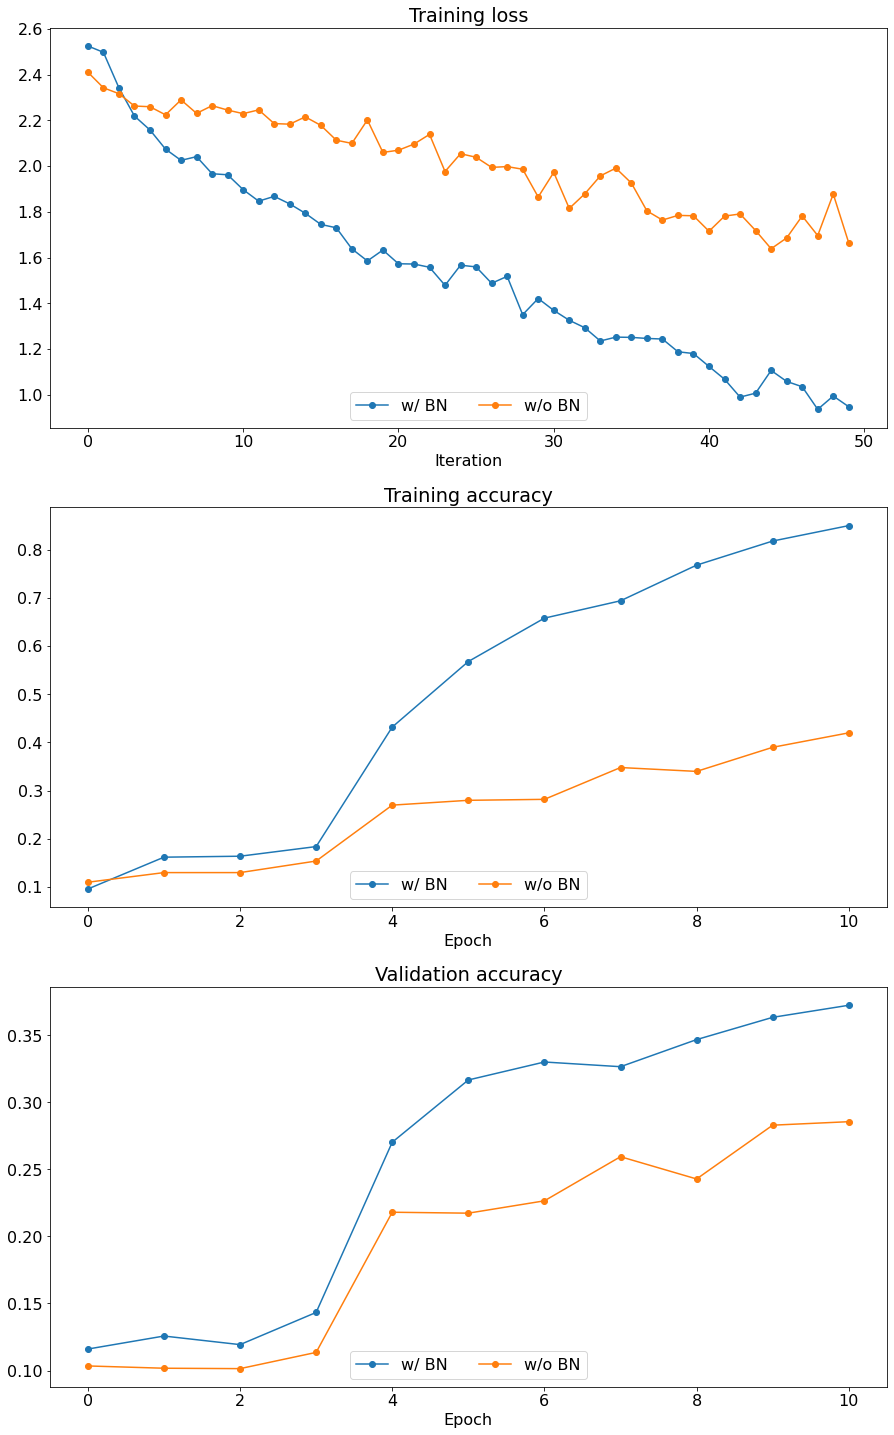

In [ ]:
def plot_training_history_bn(title, label, solvers, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
  """utility function for plotting training history"""
  plt.title(title)
  plt.xlabel(label)
  bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
  bl_plots = [plot_fn(solver) for solver in solvers]
  num_bn = len(bn_plots)
  num_bl = len(bl_plots)
  for i in range(num_bn):
    label='w/ BN'
    if labels is not None:
      label += str(labels[i])
    plt.plot(bn_plots[i], bn_marker, label=label)
  for i in range(num_bl):
    label='w/o BN'
    if labels is not None:
      label += str(labels[i])
    plt.plot(bl_plots[i], bl_marker, label=label)
  plt.legend(loc='lower center', ncol=num_bn+num_bl)

plt.subplot(3, 1, 1)
plot_training_history_bn('Training loss','Iteration', [solver], [bn_solver], \
                      lambda x: x.loss_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 2)
plot_training_history_bn('Training accuracy','Epoch', [solver], [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history_bn('Validation accuracy','Epoch', [solver], [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 25)
plt.show()

# Batch normalization and learning rate
We will now run a small experiment to study the interaction of batch normalization and learning rate.

The first cell will train convolutional networks with different learning rates. The second layer will plot training accuracy and validation set accuracy over time. 

***You should find that using batch normalization helps the network to be less dependent to the learning rate.***

i.e., the choice of learning rate will have less impact on the training
and validation accuracy

In [ ]:
#from convolutional_networks import DeepConvNet
#from fully_connected_networks import sgd_momentum
torch.manual_seed(0)

# Try training a very deep net with batchnorm
num_train = 10000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]
num_epochs = 5
lrs = [2e-1, 1e-1, 5e-2]
lrs = [5e-3, 1e-2, 2e-2]

solvers = []
for lr in lrs:
  print('No normalization: learning rate = ', lr)
  model = DeepConvNet(input_dims=input_dims, num_classes=10,
                      num_filters=[8, 8, 8],
                      max_pools=[0, 1, 2],
                      weight_scale='kaiming',
                      batchnorm=False,
                      reg=1e-5, dtype=torch.float32, device='cuda')
  solver = Solver(model, small_data,
                  num_epochs=num_epochs, batch_size=100,
                  update_rule=sgd_momentum,
                  optim_config={
                    'learning_rate': lr,
                  },
                  verbose=False, device='cuda')
  solver.train()
  solvers.append(solver)

bn_solvers = []
for lr in lrs:
  print('Normalization: learning rate = ', lr)
  bn_model = DeepConvNet(input_dims=input_dims, num_classes=10,
                         num_filters=[8, 8, 16, 16, 32, 32],
                         max_pools=[1, 3, 5],
                         weight_scale='kaiming',
                         batchnorm=True,
                         reg=1e-5, dtype=torch.float32, device='cuda')
  bn_solver = Solver(bn_model, small_data,
                     num_epochs=num_epochs, batch_size=128,
                     update_rule=sgd_momentum,
                     optim_config={
                       'learning_rate': lr,
                     },
                     verbose=False, device='cuda')
  bn_solver.train()
  bn_solvers.append(bn_solver)

No normalization: learning rate =  0.005
No normalization: learning rate =  0.01
No normalization: learning rate =  0.02
Normalization: learning rate =  0.005
Normalization: learning rate =  0.01
Normalization: learning rate =  0.02


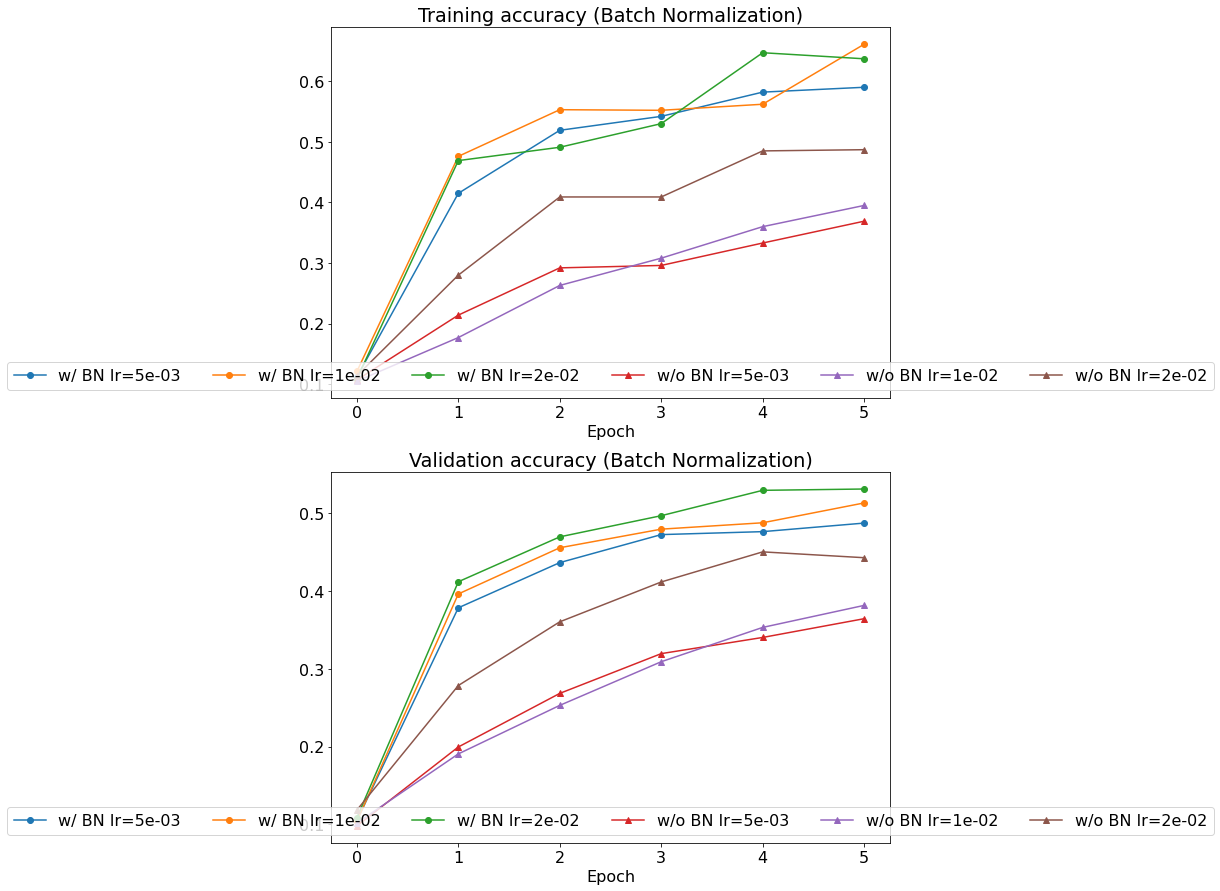

In [ ]:
plt.subplot(2, 1, 1)
plot_training_history_bn('Training accuracy (Batch Normalization)','Epoch', solvers, bn_solvers, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=[' lr={:.0e}'.format(lr) for lr in lrs])
plt.subplot(2, 1, 2)
plot_training_history_bn('Validation accuracy (Batch Normalization)','Epoch', solvers, bn_solvers, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=[' lr={:.0e}'.format(lr) for lr in lrs])

plt.gcf().set_size_inches(10, 15)
plt.show()

# Submit Your Work
After completing both notebooks for this assignment (`fully_connected_networks.ipynb` and this notebook, `convolutional_networks.ipynb`), run the following cell to create a `.zip` file for you to download and turn in. 

**Please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell:**

In [ ]:
from eecs598.submit import make_a3_submission

# TODO: Replace these with your actual uniquename and umid
uniquename = None
umid = None

make_a3_submission(GOOGLE_DRIVE_PATH, uniquename, umid)